1_results_B_other_figures.ipynb  
# Other figures (i.e. all non-transect figures made in python)

**Notebook input:**
- runs (from modeldir):
  - all runs listed in Table 4
  - all runs listed in Table C1

- seawater observations (from obsdir): 
  - Pad_Thd_IDP2021.txt (geotraces dissolved)
  - Pap_Thp_IDP2021.txt (geotraces particle-bound)
  - Deng2018Pad_Thd_formatted_uBq_per_kg.csv
  - Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv
  - Pavia2020Pad_Thd_formatted_uBq_per_kg.csv
- sediment observations (from obsdir): 
  - 1_sediment_measurements.xlsx (=Supplementary Dataset S1)
- world_41x40.BGC.nc containing dust field
- world_41x40.neph_mask.nc containing nepheloid layers *(same file is created in savedir by 0_A_neph.ipynb)*
  
**Notebook output (written to savedir):**
- Fig. 2, C3, C4: particle fields
- Fig. 6
- Fig. 7, C2: Pa export and budget, including computation
- Fig. 8
- Fig. 9
- Fig. 3b, 10, 12, C5: depth profiles per region
- Fig. S5-S7: assess model development via Atl. zonal avg
- obs_sw_GA02_sed_entire_atl_CTRL_xxxx.pdf: as Fig. S5-S7 but in 3rd column sediment Pap/Thp obs.

**Notebook comments:**   
- This notebook creates most of the figures (see *Notebook output*), including the preceding analysis. 
- Figures can be easily adapted via the settings at the top of the cell where the figure is made. For example, figures can be plotted for another run than CTRL.

# Set up notebook

**Easiest:** load conda environment for which this notebook worked.  
**Just use environment.yml (present in this folder) and follow** https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

In [1]:
from pathlib import Path         # Path objects to avoid inter-platform trouble in file paths
import platform

########## SET FILE PATHS ######################################

# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES '/' ON EVERY OPERATING SYSTEM
savedir = Path('./figures/')      # folder for saving figures & other output; (empty) directory needed
obsdir = Path('./data/')          # obs. data is loaded from here
modeldir = Path('./modeloutput/') # model output is loaded from here

## OR define modeldir depending on which system you are working on:
# if platform.system() == "Darwin":   # on Mac (e.g. laptop)
#    modeldir = Path('~/Documents/PHD/Bern3D/results')
# elif platform.system() == "Linux":  # on linux (e.g. cluster)
#    modeldir = Path('/storage/climatestor/Bern3dLPX/scheen/b3d_results')
# else:
#    raise Exception("unknown system", platform.system())

#############################################

## CHECK FILEPATHS
# expand paths because np.loadtxt can't handle home directory ~
savedir = savedir.expanduser()
obsdir = obsdir.expanduser()
modeldir = modeldir.expanduser()
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(savedir)
check_dir(obsdir)
check_dir(modeldir)

## IMPORT PACKAGES
# first time install missing packages via $conda install numpy OR $pip3 install numpy (be consistent)
import numpy as np
import xarray as xr                            # $conda install -c anaconda -n cartopy xarray; needs some time
import pandas as pd
import importlib as imp                        # to import user-defined functions; renaming new name to name of deprecated package 'imp'
import math                                    # math.e or math.exp()
import xesmf as xe                             # regridding; install via conda-forge channel e.g. !conda install -c conda-forge xesmf -y

# plot-related packages:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace
import matplotlib.cm as cmp                    # colormaps
import cmcrameri.cm as cmcr                    # better colour maps (https://www.fabiocrameri.ch/colourmaps/); $conda install -c conda-forge cmcrameri
import cartopy.crs as ccrs
import seaborn as sns

## CHECK PYTHON VERSION
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

## PLOT SETTINGS
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## PREPARE TRANSECT PLOTTING 
# (originally based on Nikki Gruber's idea to plot Atl+SO+Pac together)
from plot_surface import Surface
from plot_gruber import Gruber
from plot_profile import Profile
# needed for combining figures with pdfjam:
import os
from matplotlib.backends.backend_pdf import PdfPages
# needed for cropping white boundary:
from pdfCropMargins import crop  # installed via 'pip3 install pdfCropMargins --user --upgrade'

cmap = cmp.coolwarm
# cmap = cmcr.lapaz_r


# SET TIME OF INTEREST
# time step of interest in all cells below
t = -1

# set a random run as control simulation; doesn't matter as only model grid is used
fnctrl = modeldir / '3P5_CTRL__'

## LOAD USER-DEFINED FUNCTIONS
import functions as f                          # my own functions; call via f.function_name()

In [2]:
imp.reload(f)   # shows how to reload functions after editing functions.py w/o kernel restart

<module 'functions' from '/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py'>

# Load runs  

In [3]:
## FIRST ORGANIZE RUNNAMES & LABELS:
# SAVE ORIGINAL RUNNAMES IN CLEARER VARIABLES WITH CLEARER RUNNAMES

# result of tuning (ensemble of 3rd tuning step was called 3P5)
best_3P5_ctrl = '3P5_CTRL__'
best_3P5_norem = '3P5_NO_REM'           # no remineralization term (expect negligible); manually commented out before compiling
best_3P5_nodust = '3P5OPNDUST'          # with sigma_dusts = 0
best_3P5_noneph_sigmas = '3P5OPNNEPH'   # with sigma_nephs = 0; still with flag bottom scav. on but does nothing

# runs scaling particle export (still at AMOC of 18 Sv)
particles_ctrl_yesneph = 'PARTX1NBGC'    # same executable and parameters as control
particles_x2_yesneph = 'PARTX2NBGC'      # POC CaCO3 opal and dust fields x 2
particles_x3_yesneph = 'PARTX3NBGC'
particles_x5_yesneph = 'PARTX5NBGC'
particles_div_2_yesneph = 'PARTD2NBGC'   # divide by 2

########### FACTORIAL RUNS: VARYING AMOC AND PARTICLE FIELDS ###################
## weak AMOC
# not used in manuscript but extra info: they are the 'spinups' to adjust to FW forcing; from those runs PFREE_14SV etc are started 
weak_AMOC7 = 'WEAK_010SV'   # FW forcing of 0.10 Sv in NAtl; compensated; gives 14.0 Sv AMOC is 79%; free particles i.e. bgc
weak_AMOC6 = 'WEAK_015SV'   # FW forcing of 0.15 Sv in NAtl; compensated; gives 11.2 Sv AMOC; free particles
weak_AMOC5 = 'WEAK_020SV'   # FW forcing of 0.20 Sv in NAtl; compensated; gives 8.6 Sv AMOC is 48%; free particles

# weak AMOC, with free=bgc particles, now extending for longer s.t. Pa, Th can adjust 5kyr to a stable AMOC steady state
PFREE_14SV = 'PFREE_14SV'   # AMOC of ca 14 Sv (so 0.10Sv FW and restart from WEAK_010SV for 5kyr longer); particle field (PF) free i.e. bgc
PFREE_11SV = 'PFREE_11SV'   # AMOC of ca 11 Sv (so 0.15Sv FW and restart from WEAK_015SV for 5kyr longer); particle field (PF) free
PFREE_09SV = 'PFREE_09SV'   # AMOC of ca 9 Sv (so 0.20Sv FW and restart from WEAK_020SV for 5kyr longer); particle field (PF) free

# weak AMOC, now with fixed particles: PI particles /2, x1, x2, x3, x5
PFD2__14SV = 'PFD2__14SV'   # AMOC of ca 14 Sv (so 0.10Sv FW and restart from WEAK_010SV for 5kyr longer); particle field divided by 2
PFD2__11SV = 'PFD2__11SV'   # AMOC of ca 11 Sv (so 0.15Sv FW and restart from WEAK_015SV for 5kyr longer); particle field divided by 2
PFD2__09SV = 'PFD2__09SV'   # AMOC of ca 9 Sv (so 0.20Sv FW and restart from WEAK_020SV for 5kyr longer); particle field divided by 2

PFX1__14SV = 'PFX1__14SV'   # AMOC of ca 14 Sv; particle field multiplied by 1 (same particle fields as CTRL except not seasonal), but other circ
PFX1__11SV = 'PFX1__11SV'   # etc.
PFX1__09SV = 'PFX1__09SV'

PFX2__14SV = 'PFX2__14SV'   # AMOC of ca 14 Sv; particle field multiplied by 2
PFX2__11SV = 'PFX2__11SV'   # etc.
PFX2__09SV = 'PFX2__09SV'

PFX3__14SV = 'PFX3__14SV'
PFX3__11SV = 'PFX3__11SV'
PFX3__09SV = 'PFX3__09SV'

PFX5__14SV = 'PFX5__14SV'
PFX5__11SV = 'PFX5__11SV'
PFX5__09SV = 'PFX5__09SV'
########### END OF FACTORIAL RUNS ######################################

# set labels used in figures:
labels = {best_3P5_ctrl:'CTRL', best_3P5_nodust: 'NO_DUST', best_3P5_noneph_sigmas: 'NO_NEPH', best_3P5_norem: 'NO_REM', 
          particles_ctrl_yesneph: 'Px1_18Sv', particles_x2_yesneph: 'PART X2', particles_x3_yesneph: 'PART X3', 
          particles_x5_yesneph: 'PART X5', particles_div_2_yesneph: 'PART X0.5', 
          PFREE_14SV: 'Pdyn_14Sv', PFREE_11SV: 'Pdyn_11Sv', PFREE_09SV: 'Pdyn_9Sv',
          PFD2__14SV: 'P/2_14Sv', PFD2__11SV: 'P/2_11Sv', PFD2__09SV: 'P/2_9Sv',
          PFX1__14SV: 'Px1_14Sv', PFX1__11SV: 'Px1_11Sv', PFX1__09SV: 'Px1_9Sv',
          PFX2__14SV: 'Px2_14Sv', PFX2__11SV: 'Px2_11Sv', PFX2__09SV: 'Px2_9Sv',
          PFX3__14SV: 'Px3_14Sv', PFX3__11SV: 'Px3_11Sv', PFX3__09SV: 'Px3_9Sv',
          PFX5__14SV: 'Px5_14Sv', PFX5__11SV: 'Px5_11Sv', PFX5__09SV: 'Px5_9Sv',
          weak_AMOC5: '0.20Sv FW NAtl', weak_AMOC6: '0.15Sv FW NAtl', weak_AMOC7: '0.10Sv FW NAtl', 
          }

# in the model output simulation year 0 is called 1765 CE (pre-industrial)
yr = '.0001765'
spinup_yr = 1765

In [4]:
## LOAD RUNS

########### SETTINGS ########################################
## For all figures:
runs = [best_3P5_ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV, 
        particles_div_2_yesneph, PFD2__14SV, PFD2__11SV, PFD2__09SV,
        particles_ctrl_yesneph, PFX1__14SV, PFX1__11SV, PFX1__09SV, 
        particles_x2_yesneph, PFX2__14SV, PFX2__11SV, PFX2__09SV,
        particles_x3_yesneph, PFX3__14SV, PFX3__11SV, PFX3__09SV, 
        particles_x5_yesneph, PFX5__14SV, PFX5__11SV, PFX5__09SV,
        best_3P5_noneph_sigmas, best_3P5_nodust, best_3P5_norem]

## FASTER & LESS MEMORY ALTERNATIVE FOR Fig. 2,6,7,9,C2:
# runs = [best_3P5_ctrl, best_3P5_nodust]  # only using CTRL but need to load multiple runs
##############################################################

[datas, data_fulls] = f.load_data_multiple_runs(modeldir, runs, spinup_yr, 
                                                z_in_km=True, add_more_PaTh_vars=True)
#### INFO ####
# - timeseries data are loaded into 'datas' and have annual resolution
# - 3D variables are loaded into 'data_fulls' with lower time resolution, or only the last time step
# datas & data_fulls are dicts with keys=runnames, values=Xarray Dataset with model output of that run
##############

# Prepare landmask for surface plots
land_mask = f.get_landmask(data_fulls[runs[0]])  # doesn't matter which run (only uses model grid)

# Load observations  
Seawater observations:   
- 'obs_d': contains dissolved Pa, Th as in tuning notebooks, i.e., from Ng et al., Deng et al., Pavia et al. and GEOTRACES (all cruises except Arctic)
- 'obs_p': contains particle-bound Pa, Th as in tuning notebooks, i.e., from GEOTRACES (all cruises except Arctic)   

Sediment observations:
- 'obs_sed': contains compiled database of Atlantic sedimentary Pa/Th

In [5]:
## SEDIMENT OBS ##########################

## 1.) load sediment obs in the Atlantic:
obs_sed = pd.read_excel(obsdir / "1_sediment_measurements.xlsx")
# if XLRDError: Excel xlsx file; not supported => do $conda update pandas

## 2.) rename and shuffle columns to be similar to obs_d and obs_p
obs_sed = obs_sed.rename(columns={'Core':'core', 'Latitude':'lat', 'Longitude':'lon', 'Depth [m]':'z', 
                                  'Reference':'reference', 'Region':'region'
                                  })

# reorder columns
old_len = len(obs_sed.columns)
column_order = [0,3,2,4,1]+list(range(5,13))
obs_sed = obs_sed[obs_sed.columns[column_order]]
assert len(obs_sed.columns) == old_len, "ERROR: some columns disappeared"

# checks
for this_core in obs_sed.core.unique():
    assert len(obs_sed[obs_sed.core == this_core].z.unique()) == 1, "z of core " + this_core + " is not unique."
    assert len(obs_sed[obs_sed.core == this_core].lat.unique()) == 1, "lat of core " + this_core + " is not unique."
    assert len(obs_sed[obs_sed.core == this_core].lon.unique()) == 1, "lon of core " + this_core + " is not unique."
    
assert len(obs_sed[obs_sed.lon.isna()]) == 0, "not all rows are correct"

# change longitude axis to bern3d version; keep a lon_0_360 version as reference
obs_sed['lon_0_360'] = f.convert_minus_180_plus_180_lon_to_0_360_lon(obs_sed['lon'].values)  # change from [-180,180] to [0,360]
obs_sed['lon'] = f.convert_0_360_lon_to_model_lon(obs_sed['lon_0_360'].values)               # change from [0,360] to Bern3D [100,460]

## 3.) separate complicated structure that we have now into rows for Holocene and rows for LGM (also s.t. backwards compatable)
# separate into 2 datasets and clean up
obs_sed_Hol = obs_sed.copy(deep=True)
obs_sed_LGM = obs_sed.copy(deep=True)
del obs_sed
obs_sed_Hol.drop(['LGM Pa/Th average','# of sample for average.1','SE of included samples.1'], axis=1, inplace=True)
obs_sed_Hol.rename(columns={'Holocene Pa/Th average':'path_ratio_p',
                            'SE of included samples':'path_ratio_p_err'}, inplace=True)
obs_sed_LGM.drop(['Holocene Pa/Th average','# of sample for average','SE of included samples'], axis=1, inplace=True)
obs_sed_LGM.rename(columns={'LGM Pa/Th average':'path_ratio_p',
                            '# of sample for average.1':'# of sample for average',
                            'SE of included samples.1':'path_ratio_p_err'}, inplace=True)

# drop rows where no measurement is available; they contain '-'
obs_sed_Hol = obs_sed_Hol[obs_sed_Hol.path_ratio_p != '-']
obs_sed_LGM= obs_sed_LGM[obs_sed_LGM.path_ratio_p != '-']

# combine the 2 datasets
# add information regarding the timeslice
obs_sed_Hol['age_ka'] = ['Hol_avg'] * len(obs_sed_Hol.index)
obs_sed_LGM['age_ka'] = ['LGM_avg'] * len(obs_sed_LGM.index)
print('nr of Holocene cores:', len(obs_sed_Hol.index))
print('nr of LGM cores:', len(obs_sed_LGM.index))
obs_sed = pd.concat([obs_sed_Hol, obs_sed_LGM], axis=0, join='outer')

# reorder columns again
old_len = len(obs_sed.columns)
column_order = list(range(0,6)) + [7,11,6,8,9,10]
obs_sed = obs_sed[obs_sed.columns[column_order]]
assert len(obs_sed.columns) == old_len, "ERROR: some columns disappeared"

## 4.) take average per model grid cell
[obs_sed_model_grid, obs_sed_ave, obs_sed_ave_num] = f.obs_to_model_grid(obs_sed.set_index(['lon', 'lat', 'z'], 
                                                                                           inplace=False),
                                                                         fnctrl, weight_avg_by_uncertainty=True)
obs_sed_model_grid = obs_sed_model_grid.reset_index().set_index(['lon_sim_100_to_460','lat_sim','z_sim'], 
                                                                inplace=False)  # change index from obs to model grid
del obs_sed_ave  # got to complicated with str and floats in the age_ka column; dont want to use this anyway!

## 5.) add column delta_z in m:  if negative, then model z lies deeper than core z
obs_sed_model_grid['delta_z'] = obs_sed_model_grid.z - obs_sed_model_grid.index.get_level_values('z_sim')

## timeslice definitions:
# Hol: 0-8 ka
# LGM: 18-23 ka

# IMPORTANT: THIS DATASET IS SPLIT INTO obs_sed_Hol & obs_sed_LGM TO AVOID CONFUSION (obs_sed doesnt exist).

nr of Holocene cores: 104
nr of LGM cores: 76
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


In [6]:
## SEAWATER OBS  ################################### TAKES A WHILE (e.g. 2 minutes) ###########

## DISSOLVED SEAWATER OBS ###############

# load geotraces ICP 2021 observations; has lon [0,360]
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'
obs_d_geotraces_incl_arctic = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', 
                                                  drop_meta_data=True, good_quality=True)
obs_d_geotraces = obs_d_geotraces_incl_arctic[~obs_d_geotraces_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

# load other dissolved observations from 3 additional studies
obs_d_deng = f.get_obs_other(obsdir / 'Deng2018Pad_Thd_formatted_uBq_per_kg.csv') # is geovide
obs_d_ng = f.get_obs_other(obsdir / 'Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv')
for var in ['Pad','Pad_err','Thd','Thd_err']:
    # convert dpm/1000kg to uBq/kg; using 1 dpm = 1/60 * 1e6 uBq
    obs_d_ng[var] = obs_d_ng[var] / 60.0 * 1e3  
obs_d_pavia = f.get_obs_other(obsdir / 'Pavia2020Pad_Thd_formatted_uBq_per_kg.csv')

# combine all dissolved data excl. Arctic
obs_d = pd.concat([obs_d_geotraces,obs_d_deng,obs_d_ng,obs_d_pavia], join='outer')

# add column with ratio
obs_d['path_ratio_d'] = obs_d.Pad / obs_d.Thd

# easier to grab panda coords if lat,lon,z are not an index 
# => average obs to model grid
[obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)
obs_d.reset_index(inplace=True)


## PARTICLE-BOUND SEAWATER OBS ##########################
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'
obs_p_incl_arctic = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
obs_p = obs_p_incl_arctic[~obs_p_incl_arctic.cruise.isin(['GN01','GN02','GN03','GN04'])].copy()

# add column with ratio
obs_p['path_ratio_p'] = obs_p.Pap / obs_p.Thp

# easier to grab panda coords if lat,lon,z are not an index 
# => average obs to model grid
[obs_p, obs_p_ave, obs_p_ave_num] = f.obs_to_model_grid(obs_p, fnctrl)
obs_p.reset_index(inplace=True)

/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py:690: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(fnobs, sep='\t', header=39, dtype={'Cruise Aliases':'str'})


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Reduced dataset from  129  rows to  129  rows after deleting nans.
Reduced dataset from  20  rows to  20  rows after deleting nans.
Reduced dataset from  126  rows to  126  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.
obs_to_model_grid(): found 'Pap' as well as 'path_ratio_p' in obs.columns; continuing with Pap.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_gr

In [7]:
## define basins/cruises of interest
# using obs_d since obs_p would only give a subset of that
cruises_all = np.unique(obs_d.cruise)                      # already excludes Arctic cruises

# only 1 basin incl its SO sector
cruises_Atl = ['GA02', 'GAc02', 'GA03', 'GAc03', 'GA10','GIPY04', 'GIPY05', 
               'deng', 'ng'] # deng=geovide
cruises_Pac = ['GP16', 'GPc01', 'GSc02', 'pavia']

cruises_Atl_wo_SO = ['GA02', 'GAc02', 'GA03', 'GAc03', 'GA10',
                     'deng', 'ng'] # deng=geovide
cruises_Pac_wo_SO = ['GP16', 'GPc01']

# SO (Southern Ocean)
cruises_SO = ['GSc02','GIPY04', 'GIPY05','GIpr05', 'pavia'] 
# chosing here the definition that GA10 is not SO

# for testing purposes; not used
cruises_Arctic = ['GN01', 'GN02', 'GN03', 'GN04']  
cruises_Labr = ['GN02']

# Fig. 2, C3, C4: particle fields

run =  3P5_CTRL__


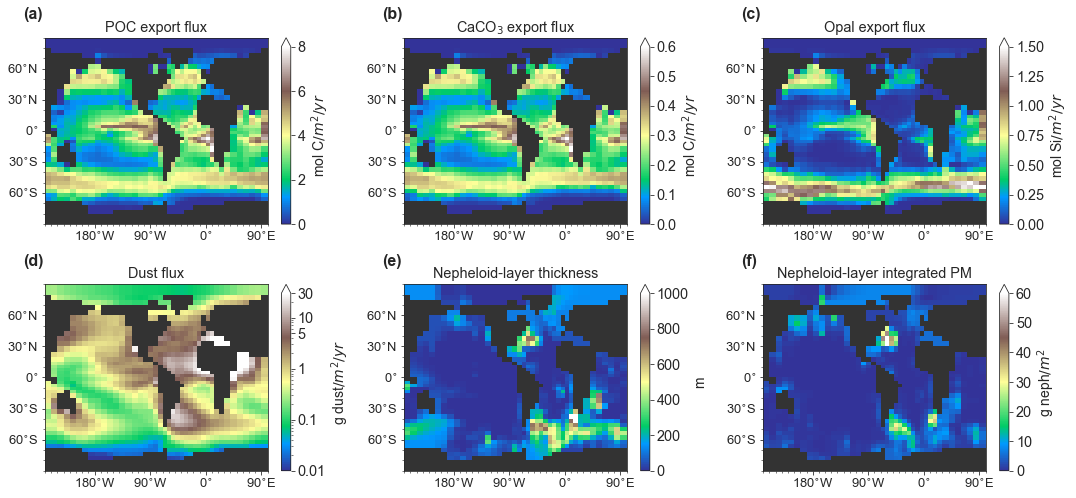

In [20]:
# Fig. 2: particle export map: all particles (biologic & lithogenic) for CTRL run

####### SETTINGS ##################################
run = best_3P5_ctrl
alpha = 1.0              # transparency
this_cmap = cmp.terrain  # nice cmaps: Dark2, Set2, Accent, Spectral_r, copper 
dust_log = False
cbar_fontsize = 14

# arrays in order of subplots:
vmins = np.asarray([[0.0, 0.0, 0.0],[0.01,0,0]])   # logarithmic scale plots cannot start at 0! Gives "invalid vmin or vmax" error
vmaxs = np.asarray([[8.0, 0.6, 1.5],[30, 1000, 60]])
titles = np.asarray([['POC', 'CaCO$_3$', 'Opal'],['Dust flux', 'Nepheloid-layer thickness', 'Nepheloid-layer integrated PM']])
# biological flux output is in C/(m^2*s) resp. Si/(m^2*s) but will convert s to yr below
units = np.asarray([['mol C$/m^{2}/yr$', 'mol C$/m^{2}/yr$', 'mol Si$/m^{2}/yr$'],['g dust$/m^{2}/yr$', 'm', 'g neph$/m^2$']])
####################################################

# read in dust field (based on Mahowald et al., 2006, JGR)
bgc_input_fields = xr.open_dataset(obsdir / 'world_41x40.BGC.nc', decode_times=False, engine="netcdf4")
dust_field = bgc_input_fields.dust_dep_mod.mean(dim='time') * 1000 # average over 12 months; result in g-dust/m**2/s
# processed here same way as in model: conversion of dust-units; kg-dust/m^2/s to g-dust/m**2/s
# now in addition convert /s to /yr
dust_field = dust_field * 365.25 * 24 * 3600  # g-dust/m**2/yr

# read in nepheloid layers
neph_fields = xr.open_dataset(obsdir / 'world_41x40.neph_mask.nc')
neph_thickness = neph_fields.neph_thickness
neph_PM = neph_fields.neph_PM / 1e3 * 1e4 # unit conversion from mg/cm2 to g/m2

# plotting
full_obj = data_fulls[run]
print('run = ',run)

sns.set_style('ticks')
fig, ax = plt.subplots(2, 3, figsize=(15,7))

X,Y = np.meshgrid(full_obj.lon_u, full_obj.lat_u) # u grid because pcolor needs left bottom corner

# ROW 1: loop over 3 biological particles
for i,var in enumerate(['FLDPOM', 'FLDCA', 'FLDOP']):
    Z = full_obj[var].isel(time=t).values * 365.25 * 24 * 3600 # convert /s to /yr
    cpf = ax[0,i].pcolormesh(X, Y, Z, cmap=this_cmap, alpha=alpha, vmin=vmins[0,i], vmax=vmaxs[0,i])
    cbar = fig.colorbar(cpf, ax=ax[0,i], extend='max')
    cbar.set_label(label=units[0,i], fontsize=cbar_fontsize)
    
    ax[0,i].pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
    ax[0,i].set_title(titles[0,i] + ' export flux')
    ax[0,i].text(-0.1, 1.1, '(' + chr(ord('a')+i) + ')', transform=ax[0,i].transAxes, 
                 size=16, weight='bold')
    
# ROW 2: lithogenic particles
# ROW 2, COL 1: dust (logarithmic scale)
for i,var in enumerate([dust_field]):   
    Z = var.values
    cpf = ax[1,i].pcolormesh(X, Y, Z, cmap=this_cmap, alpha=alpha, 
                             norm=matplotlib.colors.LogNorm(vmin=vmins[1,i], vmax=vmaxs[1,i]))
    cbar = fig.colorbar(cpf, ax=ax[1,i], extend='max')
    cbar.set_label(label=units[1,i], fontsize=cbar_fontsize)
    cticks_dust = [0.01,0.1,1,5,10,30]
    cbar.set_ticks(cticks_dust)
    cbar.set_ticklabels(cticks_dust)  # such that not printed as 10^n

    ax[1,i].pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
    ax[1,i].set_title(titles[1,i])
    ax[1,i].text(-0.1, 1.1, '(' + chr(ord('d')+i) + ')', transform=ax[1,i].transAxes, 
                 size=16, weight='bold')
    
# ROW 2, COL 2-3: neph
for i,var in enumerate([neph_thickness, neph_PM]):
    i = i+1  # because dust now in separate for loop
    Z = var.values
    cpf = ax[1,i].pcolormesh(X, Y, Z, cmap=this_cmap, alpha=alpha, vmin=vmins[1,i], vmax=vmaxs[1,i])
    cbar = fig.colorbar(cpf, ax=ax[1,i], extend='max')
    cbar.set_label(label=units[1,i], fontsize=cbar_fontsize)

    ax[1,i].pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
    ax[1,i].set_title(titles[1,i])
    ax[1,i].text(-0.1, 1.1, '(' + chr(ord('d')+i) + ')', transform=ax[1,i].transAxes, 
                 size=16, weight='bold')

for row in [0,1]:
    for col in [0,1,2]:
        ax[row,col].set_yticks(range(-60,70,30))
        ax[row,col].set_xticks([180,270,360,450])
        ax[row,col].set_xticklabels([-180,-90,0,90])  # converted the above manually from [100,460] to [-180,180]
        ax[row,col].xaxis.set_minor_locator(MultipleLocator(10))
        ax[row,col].yaxis.set_minor_locator(MultipleLocator(10))

        # add '°W' etc
        ax[row,col] = f.convert_ticks_of_map(ax[row,col], Bern3D_grid=True)
        ax[row,col].tick_params(axis='x', labelsize=13)
        ax[row,col].tick_params(axis='y', labelsize=13)
    
plt.tight_layout()
plt.savefig(savedir / 'fig2_particles_PI_biol_lith.pdf')
plt.show()

# Row 1: these patterns and colourbar maxima nicely correspond to roth14esd Fig. 1 after converting mol to mmol and 
# when converting POC from C to P via dividing by redcp = 117
# (1 mol P = 1 mol PO4 etc)

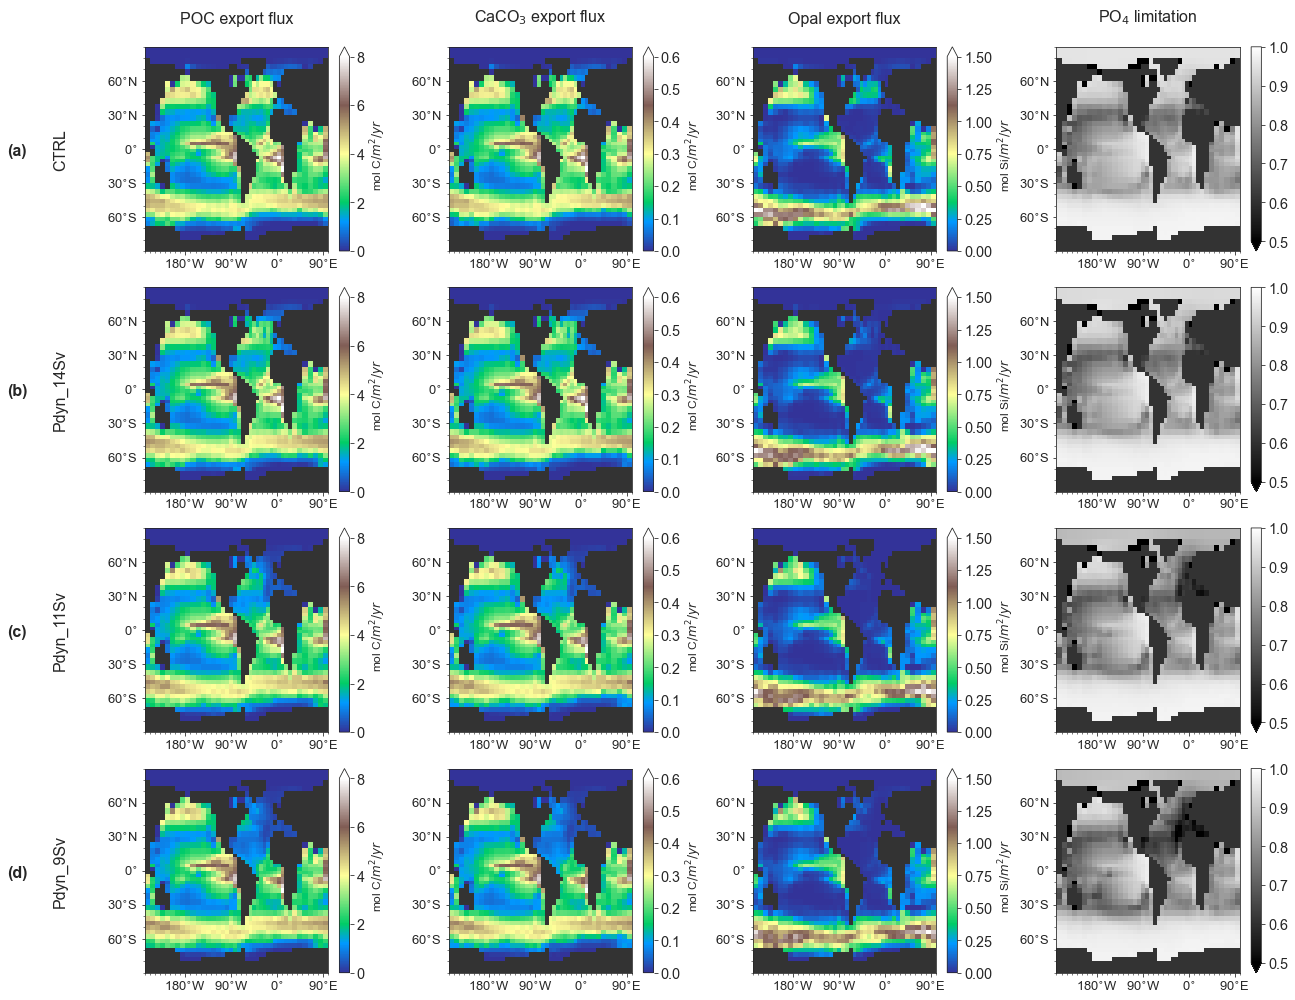

In [22]:
# Fig. C3-C4: biological particle fields for varying AMOC runs

####### SETTINGS ##################################
anom = False              # this switches between Fig. C3 and C4

zoom_atl = False
alpha = 1.0                   # transparency
this_cmap_conc = cmp.terrain  # nice cmaps cmp: Dark2, Set2, Accent, Spectral_r, copper 
this_cmap_po4lim = cmcr.grayC_r  # nice cmaps cmcr:acton, tokyo_r, grayC
dust_log = False
cbar_fontsize = 12

# arrays in order of subplots:
vmins = [0.0, 0.0, 0.0, 0.5]
vmaxs = [8.0, 0.6, 1.5, 1.0]
vmaxs_anom = [4, 0.3, 0.75, 0.3]
titles = np.asarray(['POC export flux', 'CaCO$_3$ export flux', 
                     'Opal export flux', 'PO$_4$ limitation'])
# biological flux output is in C/(m^2*s) resp. Si/(m^2*s) but will convert s to yr below
units = np.asarray(['mol C$/m^{2}/yr$', 'mol C$/m^{2}/yr$', 'mol Si$/m^{2}/yr$', ''])
####################################################

these_runs = [best_3P5_ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV]  # are runs Pdyn_ 
nr_rows = len(these_runs)
nr_cols = 4                   # variables POC CaCO3 opal and PO4_limitation

sns.set_style('ticks')
if zoom_atl:
    fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(12,nr_rows*3.5))
else:
    fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(18,nr_rows*3.5))

X,Y = np.meshgrid(data_fulls[runs[0]].lon_u, data_fulls[runs[0]].lat_u) # u grid because pcolor needs left bottom corner

for i,var in enumerate(['FLDPOM', 'FLDCA', 'FLDOP', 'FLDPLIM']):
    for row, run in enumerate(these_runs):
        full_obj = data_fulls[run]
        if var == 'FLDPLIM':
            # prepare weights for depth-weighted average over euphotic zone
            z_layer1 = (full_obj.z_w[1] - full_obj.z_w[0]).item() * 1000  # m
            z_layer2 = (0.075 - full_obj.z_w[1]).item() * 1000            # m; euphotic zone is 75 m deep (z_w[2] = 81 m)
            Z = np.average(full_obj[var].isel(time=t, z_t=slice(0,2)), axis=0, weights=[z_layer1, z_layer2])
            this_cmap = this_cmap_po4lim
            this_extend = 'min'
        else:
            Z = full_obj[var].isel(time=t).values * 365.25 * 24 * 3600 # convert /s to /yr
            this_cmap = this_cmap_conc
            this_extend = 'max'

        if not anom or row == 0:
            # non-anomaly plot
            cpf = ax[row,i].pcolormesh(X, Y, Z, cmap=this_cmap, alpha=alpha, 
                                       vmin=vmins[i], vmax=vmaxs[i])
            cbar = fig.colorbar(cpf, ax=ax[row,i], extend=this_extend)
            cbar.set_label(label=units[i], fontsize=cbar_fontsize)
        if anom: 
            if row == 0:
                Z_ref = Z
            else:
                # anomaly plot
                cpf = ax[row,i].pcolormesh(X, Y, Z-Z_ref, cmap=cmcr.vik, alpha=alpha, 
                                           vmin=-vmaxs_anom[i], vmax=vmaxs_anom[i])
                cbar = fig.colorbar(cpf, ax=ax[row,i], extend='both')
                cbar.set_label(label=units[i], fontsize=cbar_fontsize)

        ax[row,i].pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land

for row in range(nr_rows):
    if not anom or row == 0:
        ax[row,0].set_ylabel(labels[these_runs[row]]+'\n\n', fontsize=16)
    if anom and row > 0:
        ax[row,0].set_ylabel(labels[these_runs[row]]+' - '+labels[these_runs[0]]+'\n\n', fontsize=16)
    ax[row,0].text(-0.75, 0.47, '(' + chr(ord('a')+row) + ')', transform=ax[row,0].transAxes, 
                   size=16, weight='bold')
    for col in range(nr_cols):
        if row == 0:
            ax[row,col].set_title(titles[col]+'\n', fontsize=16)
        if zoom_atl:
            ax[row,col].set_xticks([270,300,330,360,390])
            ax[row,col].set_xticklabels([-90,-60,-30,0,30])        
            ax[row,col].set_xlim(258,382)
        else:
            ax[row,col].set_xticks([180,270,360,450])
            ax[row,col].set_xticklabels([-180,-90,0,90])  # converted the above manually from [100,460] to [-180,180]
        ax[row,col].set_yticks(range(-60,70,30))
        ax[row,col].xaxis.set_minor_locator(MultipleLocator(10))
        ax[row,col].yaxis.set_minor_locator(MultipleLocator(10))

        # add '°W' etc
        ax[row,col] = f.convert_ticks_of_map(ax[row,col], Bern3D_grid=True)
        ax[row,col].tick_params(axis='x', labelsize=13)
        ax[row,col].tick_params(axis='y', labelsize=13)
    
plt.tight_layout()
if anom:
    plt.savefig(savedir / ('figC4_particle_response_anom.pdf'))
else:
    plt.savefig(savedir / ('figC3_particle_response.pdf'))
plt.show()

**Intermezzo: how many cells high is the nepheloid layer?**

In [10]:
# we compute nr of cells in neph. layer and on the go the bottom depth of the ocean as well (can be used later in map of cores)

tmp_obj = data_fulls[runs[0]]

# initialize with 0s i.e. land everywhere
bottom_z_t_index = xr.DataArray(data=np.zeros((40,41)),
                                dims=['lat_t', 'lon_t'],
                                coords={'lon_t': (['lon_t'], tmp_obj.lon_t.data,
                                                  {'units': "degrees_east", 'long_name': "Longitude", 'standard_name': "longitude", 'axis': "X"}),
                                        'lat_t': (['lat_t'], tmp_obj.lat_t.data,
                                                  {'units': "degrees_north", 'long_name': "Latitude", 'standard_name': "latitude", 'axis': "Y"})})
# to save bottom depth in meter
bottom_m = xr.DataArray(data=np.zeros((40,41)),
                        dims=['lat_t', 'lon_t'],
                        coords={'lon_t': (['lon_t'], tmp_obj.lon_t.data,
                                          {'units': "degrees_east", 'long_name': "Longitude", 'standard_name': "longitude", 'axis': "X"}),
                                'lat_t': (['lat_t'], tmp_obj.lat_t.data,
                                          {'units': "degrees_north", 'long_name': "Latitude", 'standard_name': "latitude", 'axis': "Y"})})
# initialize with 0s i.e. no neph layer
nr_neph_cells = xr.DataArray(data=np.zeros((40,41)),
                             dims=['lat_t', 'lon_t'],
                             coords={'lon_t': (['lon_t'], tmp_obj.lon_t.data,
                                               {'units': "degrees_east", 'long_name': "Longitude", 'standard_name': "longitude", 'axis': "X"}),
                                     'lat_t': (['lat_t'], tmp_obj.lat_t.data,
                                               {'units': "degrees_north", 'long_name': "Latitude", 'standard_name': "latitude", 'axis': "Y"})})

for lat in range(len(tmp_obj.lat_t)):
    for lon in range(len(tmp_obj.lon_t)):
        ## FIND OCEAN BOTTOM AND SAVE IN bottom_m
        # find 1st z_t index hitting land; using that mask is 0 where land or sediment
        try:
            z_t_index = np.where(tmp_obj.mask.isel(lat_t=lat,lon_t=lon) == 0)[0][0]
            # z_t_index = list(tmp_obj.mask.isel(lat_t=lat,lon_t=lon)).index(0)     # equivalent but slower
        except:
            # 0 is not in the list => water column has maximal depth of 32 grid cells
            z_t_index = 32
        bottom_z_t_index[lat,lon] = z_t_index
        # the upper boundary of this z_t cell is bottom_m in km. This is the same as same index in z_w
        this_z_bottom = tmp_obj.z_w[z_t_index] * 1000  # z_w in km; convert to m
        if this_z_bottom > 0.0:  # otherwise already initialized as 0
            bottom_m[lat,lon] = this_z_bottom

        ## FIND nr_neph_cells AND SAVE
        if np.isnan(neph_thickness[lat,lon]):
            nr_neph_cells[lat,lon] = 0
        else:
            # nepheloid layers extend from the bottom to (bottom minus neph_thickness)
            neph_lower_bnd = this_z_bottom
            neph_upper_bnd = this_z_bottom - neph_thickness[lat,lon]
            assert neph_lower_bnd >= neph_upper_bnd, "neph_lower_bnd is above neph_upper_bnd"

            # in which grid cell fall the neph boundaries?
            z_t_lower = np.where(neph_lower_bnd <= abs(tmp_obj.z_w * 1000))[0][0]-1  # neph_lower_bnd lies in this z_t index
            z_t_upper = np.where(neph_upper_bnd <= abs(tmp_obj.z_w * 1000))[0][0]-1  # neph_upper_bnd lies in this z_t index
            assert z_t_lower >= z_t_upper, "z_t_lower is above z_t_upper"
            if z_t_lower == z_t_upper and neph_lower_bnd - neph_upper_bnd > 1.0e-5:
                # boundaries lie in the same grid cell but are spaced apart
                nr_neph_cells[lat,lon] = 1
            else:
                nr_neph_cells[lat,lon] = z_t_lower - z_t_upper

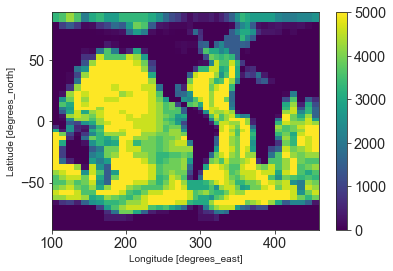

In [11]:
# plot ocean bottom result
bottom_m.plot()
plt.show()

In [12]:
# find average height of bottom cell
all_bottom_indices = np.ravel(bottom_z_t_index) # still includes land
ocean_bottom_indices = np.asarray(all_bottom_indices[all_bottom_indices>0.0], dtype=int)
cell_heights = np.diff(tmp_obj.z_w * 1000) # km to m
avg_bottom_cell_height = cell_heights[ocean_bottom_indices-1].mean()
print('Average height of bottom cell:', round(avg_bottom_cell_height), 'm')

Average height of bottom cell: 285 m


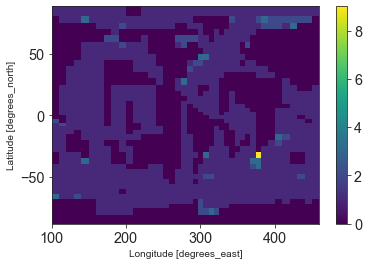

In [13]:
# plot nr_neph_cells result
nr_neph_cells.plot()
plt.show()

In [14]:
# count values in nr_neph_cells:
from collections import Counter
Counter([f'{x} ({x})' for x in np.ravel(nr_neph_cells.values)])

Counter({'0.0 (0.0)': 651,
         '1.0 (1.0)': 936,
         '2.0 (2.0)': 38,
         '3.0 (3.0)': 14,
         '9.0 (9.0)': 1})

In [15]:
# investigate the outlier with 9 cells
[x,y] = np.where(nr_neph_cells > 5)
nr_neph_cells[x.item(),y.item()]
# => this grid cell at 378, -32.5 borders South Africa in the North and East; it is 11 cells deep namely 640m. 

<xarray.DataArray ()>
array(9.)
Coordinates:
    lon_t    float64 378.0
    lat_t    float64 -32.5

**Answer: maximum number of nepheloid grid cells in height in the open ocean is 3.** There is 1 location with more than 3, which is shallow (640 m) and is at the coast off South Africa (9 grid cells high i.e. from 640-80m. )

# Fig. 6: Bottom Pap/Thp

In [26]:
## PREPARATION
# ADD path_ratio_p_bottom for this run to its data_fulls; ALSO compute bottom depth in meters in 'bottom_m' (independent of run)

########### SETTINGS ########################################
run = best_3P5_ctrl
#############################################################

# initialize obj to save bottom depth in meter; for bottom_m which run doesn't matter
bottom_m = xr.DataArray(data=np.zeros((40,41)),
                        dims=['lat_t', 'lon_t'],
                        coords={'lon_t': (['lon_t'], data_fulls[run].lon_t.data,
                                          {'units': "degrees_east", 'long_name': "Longitude", 'standard_name': "longitude", 'axis': "X"}),
                                'lat_t': (['lat_t'], data_fulls[run].lat_t.data,
                                          {'units': "degrees_north", 'long_name': "Latitude", 'standard_name': "latitude", 'axis': "Y"})})
print('run = ',run)
print("timestep: t=",t, '\n')

full_obj = data_fulls[run]

# we compute Pap/Thp in the bottommost cell & bottom depth of the ocean in meters
# this is adapted from a copy of the intermezzo under 'Particle fields' without the nr_neph_cells part TODO combine

# initialize with 0s
path_ratio_p_bottom = xr.DataArray(data=np.zeros((40,41)),
                                   dims=['lat_t', 'lon_t'],
                                   coords={'lon_t': (['lon_t'], full_obj.lon_t.data,
                                              {'units': "degrees_east", 'long_name': "Longitude", 
                                              'standard_name': "longitude", 'axis': "X"}),
                                           'lat_t': (['lat_t'], full_obj.lat_t.data,
                                              {'units': "degrees_north", 'long_name': "Latitude", 
                                              'standard_name': "latitude", 'axis': "Y"})})
for lat in range(len(full_obj.lat_t)):
      for lon in range(len(full_obj.lon_t)):
            ## FIND OCEAN BOTTOM AND SAVE IN bottom_m
            # find 1st z_t index hitting land/sediment; using that mask is 0 where land or sediment
            try:
                  z_t_index_sed = np.where(full_obj.mask.isel(lat_t=lat,lon_t=lon) == 0)[0][0]
                  # z_t_index_sed = list(tmp_obj.mask.isel(lat_t=lat,lon_t=lon)).index(0)     # equivalent but slower
            except:
                  # 0 is not in the list => water column has maximal depth of 32 grid cells, so sediment is hypothetically the 33th cell, i=32
                  z_t_index_sed = 32
                  
            # the upper boundary of the z_t_index_sed cell is bottom_m in km. This is the same index in z_w
            this_z_bottom = full_obj.z_w[z_t_index_sed] * 1000  # z_w in km; convert to m
            if this_z_bottom > 0.0:  # otherwise already initialized as 0
                  bottom_m[lat,lon] = this_z_bottom  # INDEPENT OF RUN

            ## FIND PAP/THP AT BOTTOM AND SAVE IN path_ratio_p_bottom
            # model has nan values at sediment cell so we need to go 1 cell up to get the bottommost water cell
            if z_t_index_sed == 0:
                  path_ratio_p_bottom[lat,lon] = np.nan  # no ocean here 
            else:
                  path_ratio_p_bottom[lat,lon] = full_obj.path_ratio_p.isel(time=t, lat_t=lat, lon_t=lon, z_t=z_t_index_sed - 1)

# save results for this run
data_fulls[run]['path_ratio_p_bottom'] = path_ratio_p_bottom
    
print('path_ratio_p_bottom variables are added to data_fulls for run',run)

run =  3P5_CTRL__
timestep: t= -1 



path_ratio_p_bottom variables are added to data_fulls for run 3P5_CTRL__


run =  3P5_CTRL__


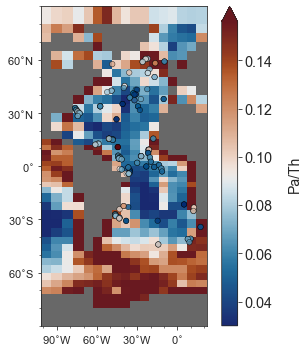

In [27]:
# Fig. 6: plot Pap/Thp bottom

########### SETTINGS ########################################
run = best_3P5_ctrl

zoom_atl = True
alpha_model = 0.9  # transparency
alpha_obs = 0.8    # transparency
size = 30          # marker size for obs
this_cmap = cmcr.vik
title = 'Sedimentary $Pa/Th$'
# choose vmin and vmax s.t. production ratio 0.093 is in the middle:
vmin = 0.03
vmax = 0.156
########### END OF SETTINGS #################################

full_obj = data_fulls[run]
print('run = ',run)

sns.set_style('ticks')
if zoom_atl:
    fig, ax = plt.subplots(1, figsize=(4.3,5))
else:
    fig, ax = plt.subplots(1, figsize=(6,5))

X,Y = np.meshgrid(full_obj.lon_u, full_obj.lat_u) # u grid because pcolor needs left bottom corner

# PLOT
Z = full_obj.path_ratio_p_bottom.values
cpf = ax.pcolormesh(X, Y, Z, cmap=this_cmap, alpha=alpha_model, vmin=vmin, vmax=vmax)
# nice cmaps: Dark2, Set2, Accent, Spectral_r, copper 
cbar = fig.colorbar(cpf, ax=ax, extend='max', pad=0.07)
cbar.set_label(label='Pa/Th', fontsize=14, labelpad=15)

ax.pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.25) # add land

# TITLE, TICKS
# ax.set_title(title)
ax.set_yticks(range(-60,70,30))
if zoom_atl:
    ax.set_xticks([270,300,330,360,390])
    ax.set_xticklabels([-90,-60,-30,0,30])        
else:
    ax.set_xticks([180,270,360,450])
    ax.set_xticklabels([-180,-90,0,90])
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(10))
if zoom_atl:
    ax.set_xlim(258,382)

# add '°W' etc
ax = f.convert_ticks_of_map(ax, Bern3D_grid=True)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

# ADD SEDIMENT OBSERVATIONS
ax.scatter(x=obs_sed.lon, y=obs_sed.lat, c=obs_sed.path_ratio_p, 
           marker='o', s=size, lw=0.5, edgecolor='k', alpha=alpha_obs,
           cmap=this_cmap, vmin=vmin, vmax=vmax)

plt.tight_layout()
if zoom_atl:
    plt.savefig(savedir / ('fig6_PapThp_bottom_run_' + run + '_zoom_atl.pdf'))
else:
    plt.savefig(savedir / ('PapThp_bottom_run_' + run + '.pdf'))
plt.show()

# Fig. 7, C2: Pa export and budget, including computation
### Fig 7 is made manually (in fig7_PaTh_budget.pptx based on Deng et al.) but numbers needed for it are computed here
We can produce a figure (or just the numbers) similar to Deng et al. 2018 bgs, Fig. 11. Note that they do not write in that figure the amount of removal to the sediment (Table S4), since that follows directly from production and net advection.  

We can estimate in the same 2 regions the terms of the budget in our case. Here we don't care about dissolved vs. particle-bound parts but we consider the total. (Of course, only the particle-bound form sinks to the sediment).

**Define masks ca. according to Deng et al. NAtl and SAtl**

In [5]:
## CORRECT VERSION WITH S Atl South boundary with a bend towards South Africa as it is in Deng 2014

## fill masks with the entire region of NAtl an SAtl
# fill mask_NAtl_Deng and mask_SAtl_Deng with 1 where mask lies in desired 3D region; -1 elsewhere and 0 in land/sediment
# approximation of GEOVIDE on Bern3D grid; list of grid cells (python indices) from north of 40N up to GEOVIDE:
# IF CHANGED: NEED TO CHANGE THE OBJECTS ABOVE AS WELL (cell_inside_N_bnd_Tgrid etc.)
top_of_NAtl_list = [(23,34),(24,34),(25,34),
                    (22,33),(23,33,),(24,33),(25,33),
                    (21,32),(22,32),(23,32),(24,32),(25,32),(26,32),
                    (20,31),(21,31),(22,31),(23,31),(24,31),(25,31),(26,31),(27,31)]
# fortran indices (dont use):
# top_of_NAtl_list = [(24,35),(25,35),(26,35),
#                     (23,34,),(24,34),(25,34),(26,34),
#                     (22,33),(23,33),(24,33),(25,33),(26,33),(27,33),
#                     (21,32),(22,32),(23,32),(24,32),(25,32),(26,32),(27,32),(28,32)]

# SOUTHERN TRANSECT (WOCE A11) on Bern3D grid: 
# list of grid cells (python indices) to include that lie south of 30S
bottom_of_SAtl_list = [        (22,12),(23,12),(24,12),(25,12),(26,12),(27,12),(28,12),(29,12),(30,12),(31,12),
                               (22,11),(23,11),(24,11),(25,11),(26,11),(27,11),(28,11),(29,11),
                       (21,10),(22,10),(23,10),(24,10),(25,10),(26,10),(27,10),(28,10)]
# fortran indices (dont use):
# bottom_of_SAtl_list = [        (23,13),(24,13),(25,13),(26,13),(27,13),(28,13),(29,13),(30,13),(31,13),(32,13)
#                                (23,12),(24,12),(25,12),(26,12),(27,12),(28,12),(29,12),(30,12),
#                        (22,11),(23,11),(24,11),(25,11),(26,11),(27,11),(28,11),(29,11)]

run = best_3P5_ctrl  # run doesn't matter (only used for grid)
full_obj = data_fulls[run]
mask_NAtl_Deng = full_obj.masks.copy(deep=True)
mask_SAtl_Deng = full_obj.masks.copy(deep=True)
for i,lon in enumerate(full_obj.lon_t):
    for j,lat in enumerate(full_obj.lat_t):
        if full_obj.masks.isel(lon_t=i, lat_t=j, z_t=0) == 1.0:
            # Atlantic basin=1
            if (i,j) in bottom_of_SAtl_list:
                # South Atlantic part 1: south of 30S with southern boundary following WOCE line A11 on Bern3D grid
                mask_NAtl_Deng[:,j,i] = [-1.0] * 32
                mask_SAtl_Deng[:,j,i] = full_obj.masks.isel(lon_t=i, lat_t=j).values  # fills with 1; still 0 in sediment
            elif lat < -6.0 and lat > -30.0 and lon < 382.0:
                # South Atlantic part 2: north of 30S, taken W to E entirely, with upper u-grid boundary 6S (Deng: 4.5 S)
                # and 382.0 (taking 1 column less south of Africa)
                mask_NAtl_Deng[:,j,i] = [-1.0] * 32                                    # order z, lat, lon
                mask_SAtl_Deng[:,j,i] = full_obj.masks.isel(lon_t=i, lat_t=j).values  # fills with 1; still 0 in sediment
            elif (lat > -6.0 and lat < 40) or ((i,j) in top_of_NAtl_list):
                # North Atlantic with u-grid boundary 6S and GEOVIDE converted onto Bern3D grid
                mask_NAtl_Deng[:,j,i] = full_obj.masks.isel(lon_t=i, lat_t=j).values  # fills with 1; still 0 in sediment
                mask_SAtl_Deng[:,j,i] = [-1.0] * 32
            else:
                # outside interesting part of Atlantic
                mask_NAtl_Deng[:,j,i] = [-1.0] * 32
                mask_SAtl_Deng[:,j,i] = [-1.0] * 32
        elif full_obj.masks.isel(lon_t=i, lat_t=j, z_t=0) == 0.0:
            # land: set value to 0 instead of -1 such that plots more visible
            mask_NAtl_Deng[:,j,i] = [0.0] * 32
            mask_SAtl_Deng[:,j,i] = [0.0] * 32
        else:
            # not in Atlantic basin
            mask_NAtl_Deng[:,j,i] = [-1.0] * 32
            mask_SAtl_Deng[:,j,i] = [-1.0] * 32

### Fig. C2: boundaries of NAtl and SAtl definition
Transects added manually in figC2_NAtl_SAtl_boundaries.pptx

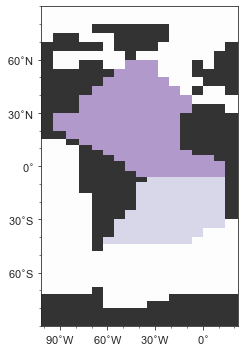

In [6]:
# plot sub-basin definitions

sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(3.5,5))

full_obj = data_fulls[run]  # only used for grid
X,Y = np.meshgrid(full_obj.lon_u, full_obj.lat_u) # u grid because pcolor needs left bottom corner

Z = (0.5 * mask_SAtl_Deng.isel(z_t=0) + mask_NAtl_Deng.isel(z_t=0)).values
cpf = ax.pcolormesh(X, Y, Z, cmap='Purples', alpha=0.4)#, vmin=-0.5, vmax=1.0)  

# fig.colorbar(cpf, ax=ax, extend='max')

ax.pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
ax.set_yticks(range(-60,70,30))
ax.set_xticks([270,300,330,360,390])
ax.set_xticklabels([-90,-60,-30,0,30])
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.set_xlim(258,382)

# add '°W' etc
ax = f.convert_ticks_of_map(ax, Bern3D_grid=True)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.savefig(savedir / ('figC2_before_edit_NAtl_SAtl_boundaries_wo_transects.pdf'))
plt.show()

**Compute each term of the Pa and Th budget in this NAtl and SAtl region**   
1. production (Ad)  
2. transport with circulation via advection (Ad; neglecting Ap)  
3. removal to sediment (Ap)  
4. radioactive decay (Ad and Ap) => negligible so not used  
5. residual => is total production (1) minus the other processes (2 and 3).   
Represents horizontal diffusion of Pa, Th due to gradients in Pa, Th plus model uncertainty  

N.B. scavenging and remineralization => can be ignored since it is only an exchange between Ad and Ap

In [7]:
########### SETTINGS ##################################
run = best_3P5_ctrl
########### END OF SETTINGS ###########################

full_obj = data_fulls[run].isel(time=t)
print('run = ',run)
print("timestep: t=",t,'is', round(data_fulls[run].time[t].item()),'yr\n')

############################################

## 1). PRODUCTION: compute from water volume and production rate
prod_rate_Pa = 2.33e-3  # in dpm/m3/yr
prod_rate_Th = 2.52e-2

vol_NAtl_Deng = full_obj.boxvol.where(mask_NAtl_Deng == 1.0).sum().item()  # in m3
vol_SAtl_Deng = full_obj.boxvol.where(mask_SAtl_Deng == 1.0).sum().item()

print("Volume in NAtl:", "{:.4e}".format(vol_NAtl_Deng), "(Deng et al. 2018: 1.48e17 m3)")
print("Volume in SAtl:", "{:.4e}".format(vol_SAtl_Deng), "(Deng et al. 2018: 1.02e17 m3)\n")

# multiply; convert /yr to /s and dpm to uBq => result in uBq/s
prod_Pa_NAtl = prod_rate_Pa * vol_NAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60
prod_Pa_SAtl = prod_rate_Pa * vol_SAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60
prod_Th_NAtl = prod_rate_Th * vol_NAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60
prod_Th_SAtl = prod_rate_Th * vol_SAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60

print('1.) PRODUCTION of Pa:', "{:.4e}".format(prod_Pa_NAtl), 'uBq/s in NAtl and ', 
      "{:.4e}".format(prod_Pa_SAtl), 'uBq/s in SAtl')
print('1.) PRODUCTION of Th:', "{:.4e}".format(prod_Th_NAtl), 'uBq/s in NAtl and ', 
      "{:.4e}".format(prod_Th_SAtl), 'uBq/s in SAtl')

print('\nDeng et al. 2018 has production \nfor Pa: 1.86e11 and 1.28e11 \nfor Th: 2.008e12 and 1.384e12\n')
# conclusion: our NAtl volume is very similar to Deng et al.'s; our SAtl volume is slightly larger (ca 5%)

############################################

## 2). NET MERIDIONAL TRANSPORT

## GROSS MERIDIONAL TRANSPORT - NOW DIRECTLY FROM v and concentration: v * A * [Pad] with A area of lon-z grid surface
# v includes advection and diffusion (also GM) of water itself
# Here we compute meridional advection of Pa, Th with the water. 
# Thus diffusion of Pa, Th (due to gradient fields of Pa, Th) is not taken into account.

print('positive means transport directed northward:')
##### GEOVIDE TRANSECT #####
# defining inside vs outside s.t. resulting transport (from inside to outside) is directed northward
# walking over the boundary from W to E (8 cells); double if multiple fluxes involved (11 in total)
cell_inside_bnd_Tgrid = [(22,33),(23,34),(24,34),(25,34),(25,34),(25,33),(26,32),(26,32),(27,31),(27,31),(28,30)]
# flux is going to this cell outside bnd, in same order:
cell_outside_bnd_Tgrid = [(22,34),(22,34),(24,35),(25,35),(26,34),(26,33),(26,33),(27,32),(27,32),(28,31),(28,31)]
flux_type = ['v','u','v','v','u','u','v','u','v','u','v']
# N.B. we omit the Mediterranian inlet (inside_cell=(28,30); outside_cell=(29,30)) because GEOVIDE did not cross it
[merid_transp_Pa_N, merid_transp_Th_N] = f.compute_merid_transport_across_section(full_obj, cell_inside_bnd_Tgrid, 
                                                                                  cell_outside_bnd_Tgrid, flux_type)
print('MERIDIONAL TRANSPORT OF Pa ACROSS GEOVIDE:', 
      "{:.4e}".format(merid_transp_Pa_N), 'uBq/s  (Deng et al. 2018: -1.21e10)')
print('MERIDIONAL TRANSPORT OF Th ACROSS GEOVIDE:', 
      "{:.4e}".format(merid_transp_Th_N), 'uBq/s  (Deng et al. 2018: -3.15e10)\n')

##### EQUATOR TRANSECT AT 6S #####
# defining inside vs outside s.t. resulting transport (from inside to outside) is directed northward
cell_inside_bnd_Tgrid = [(25,18),(26,18),(27,18),(28,18),(29,18),(30,18),(31,18)]
cell_outside_bnd_Tgrid = [(25,19),(26,19),(27,19),(28,19),(29,19),(30,19),(31,19)]
flux_type = ['v']*7
[merid_transp_Pa_EQ, merid_transp_Th_EQ] = f.compute_merid_transport_across_section(full_obj, cell_inside_bnd_Tgrid, 
                                                                                    cell_outside_bnd_Tgrid, flux_type)
print('MERIDIONAL TRANSPORT OF Pa ACROSS 6S:', 
      "{:.4e}".format(merid_transp_Pa_EQ), 'uBq/s  (Deng et al. 2018: -5.97e10)')
print('MERIDIONAL TRANSPORT OF Th ACROSS 6S:', 
      "{:.4e}".format(merid_transp_Th_EQ), 'uBq/s  (Deng et al. 2018: -10.9e10)\n')

##### SOUTHERN TRANSECT: VERSION WOCE LINE A11 (with bend) #####
cell_inside_bnd_Tgrid = [(21,9),(22,9),(23,9),(24,9),(25,9),(26,9),(27,9),
                         (28,9),(29,10),(29,10),(30,11),(30,11),(31,11),(32,12)]
cell_outside_bnd_Tgrid = [(21,10),(22,10),(23,10),(24,10),(25,10),(26,10),(27,10),
                         (28,10),(28,10),(29,11),(29,11),(30,12),(31,12),(31,12)]
flux_type = ['v']*7+['v','u','v','u','v','v','u']
[merid_transp_Pa_S, merid_transp_Th_S] = f.compute_merid_transport_across_section(full_obj, cell_inside_bnd_Tgrid, 
                                                                                  cell_outside_bnd_Tgrid, flux_type)
print('MERIDIONAL TRANSPORT OF Pa ACROSS 44S:', 
      "{:.4e}".format(merid_transp_Pa_S), 'uBq/s  (Deng et al. 2018: -5.95e10)')
print('MERIDIONAL TRANSPORT OF Th ACROSS 44S:', 
      "{:.4e}".format(merid_transp_Th_S), 'uBq/s  (Deng et al. 2018: -10.6e10)\n')

##### ADVECTIVE FLUX INTO MEDITERRANEAN as extra source/sink in NAtl #####
# defining inside vs outside s.t. resulting transport (from inside to outside) is directed from Atl into Med.
cell_inside_bnd_Tgrid = (28,30)
cell_outside_bnd_Tgrid = (29,30)
flux_type = 'u'
[merid_transp_Pa_med, merid_transp_Th_med] = f.compute_transport_over_1_cell(full_obj, cell_inside_bnd_Tgrid, 
                                                                             cell_outside_bnd_Tgrid, flux_type)
print('positive means transport directed from Atl to Med:')
print('MERIDIONAL TRANSPORT OF Pa INTO MEDITERRANEAN:', "{:.4e}".format(merid_transp_Pa_med), 'uBq/s')
print('MERIDIONAL TRANSPORT OF Th INTO MEDITERRANEAN:', "{:.4e}".format(merid_transp_Th_med), 'uBq/s\n')
# small but can matter in 2nd decimal

## NET ####
# We find the net meridional transport in e.g. the NAtl between GEOVIDE and 6S 
# by 6S transport (southern transect) minus GEOVIDE transport (northern transect), while keeping the signs as they are. 
# Meaning: positive net meridional transport in NAtl means net into the NAtl; neg out of the NAtl

net_mer_transport_Pad_NAtl = merid_transp_Pa_EQ - merid_transp_Pa_N - merid_transp_Pa_med
net_mer_transport_Thd_NAtl = merid_transp_Th_EQ - merid_transp_Th_N - merid_transp_Th_med
net_mer_transport_Pad_SAtl = merid_transp_Pa_S - merid_transp_Pa_EQ
net_mer_transport_Thd_SAtl = merid_transp_Th_S - merid_transp_Th_EQ

print('positive means net transport into the sub-basin (negative out of the sub-basin):')
print('2). NET MERIDIONAL TRANSPORT of Pa:', 
      "{:.4e}".format(net_mer_transport_Pad_NAtl), 'uBq/s in NAtl and ', 
      "{:.4e}".format(net_mer_transport_Pad_SAtl), 'uBq/s in SAtl')
print('2). NET MERIDIONAL TRANSPORT of Th:', 
      "{:.4e}".format(net_mer_transport_Thd_NAtl), 'uBq/s in NAtl and ', 
      "{:.4e}".format(net_mer_transport_Thd_SAtl), 'uBq/s in SAtl')

print('\nDeng et al. 2018 has net meridional transport \nfor Pa: -4.75e10 and 0.017e10 \nfor Th: -7.76e10 and 0.33e10')  
# I changed the signs of Deng in Table S4 to mean pos. values indicating into the sub-basin (my notation)

############################################

## 3). REMOVAL TO SEDIMENT: compute from particle-bound concentration & delta_z of bottommost grid cell

# amount of Ap sinking out of bottommost cell into sediment in 1 timestep: ws * delta_t / delta_z * Ap   
# (ws in m/yr so delta_t in yr for result to have unit of Ap: delta_t = 1/96 yr)
# amount in 1 second (instead of in 1 timestep): ws * delta_t / delta_z * 96/(365.25 * 24 * 3600) * Ap

ws = 1600.0        # m/yr
delta_t = 1/96.0   # yr
# The wanted result is multiplying the factor
factor = ws * delta_t * 96/(365.25 * 24 * 3600) 
# with Ap[dpm] / delta_z[m], both diagnosed in the bottommost grid cell.
# Model output of Ap is in dpm/m3 so we need to multiply with V[m3]. Simplify:
# Ap[dpm/m3] * V[m3] / delta_z[m] = Ap[dpm/m3] * A[m2]


# --- INTERMEZZO ------------------------------ find bottommost grid cells ------
# (TODO similar to copy in other parts of this notebook BUT adapted to be of int type > put into function!)
tmp_obj = data_fulls[run]
# initialize with 0s i.e. land everywhere
bottom_z_t_index = xr.DataArray(data=np.zeros((40,41)),
                                dims=['lat_t', 'lon_t'],
                                coords={'lon_t': (['lon_t'], tmp_obj.lon_t.data,
                                                  {'units': "degrees_east", 'long_name': "Longitude", 
                                                   'standard_name': "longitude", 'axis': "X"}),
                                        'lat_t': (['lat_t'], tmp_obj.lat_t.data,
                                                  {'units': "degrees_north", 'long_name': "Latitude", 
                                                   'standard_name': "latitude", 'axis': "Y"})})
for lat in range(len(tmp_obj.lat_t)):
    for lon in range(len(tmp_obj.lon_t)):
        ## FIND OCEAN BOTTOM AND SAVE IN bottom_m
        # find 1st z_t index hitting land; using that mask is 0 where land or sediment
        try:
            z_t_index = np.where(tmp_obj.mask.isel(lat_t=lat,lon_t=lon) == 0)[0][0]
            # z_t_index = list(tmp_obj.mask.isel(lat_t=lat,lon_t=lon)).index(0)     # equivalent but slower
        except:
            # 0 is not in the list => water column has maximal depth of 32 grid cells
            z_t_index = 32
        if z_t_index > 0:
            bottom_z_t_index[lat,lon] = z_t_index  
            # fortran indices: 0 on land; 1 means water column is 1 grid cell deep, etc
bottom_z_t_index = bottom_z_t_index.astype(int)
# -------------------------------------------------------------------------------


Pap_bottom_dpm_NAtl = full_obj.Pap.where(mask_NAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
Thp_bottom_dpm_NAtl = full_obj.Thp.where(mask_NAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
Pap_bottom_dpm_SAtl = full_obj.Pap.where(mask_SAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
Thp_bottom_dpm_SAtl = full_obj.Thp.where(mask_SAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
# TODO this is a much simpler implementation of pap_bottom used in plot above

# sum and convert from dpm to uBq
to_sed_Pap_NAtl = (factor * Pap_bottom_dpm_NAtl * full_obj.area).sum().item() * 1e6 / 60
# Pap_bottom_dpm_NAtl contains nan where land so taken care off
to_sed_Thp_NAtl = (factor * Thp_bottom_dpm_NAtl * full_obj.area).sum().item() * 1e6 / 60
to_sed_Pap_SAtl = (factor * Pap_bottom_dpm_SAtl * full_obj.area).sum().item() * 1e6 / 60
to_sed_Thp_SAtl = (factor * Thp_bottom_dpm_SAtl * full_obj.area).sum().item() * 1e6 / 60

print('\n3). REMOVAL TO SEDIMENT of Pa:', "{:.5e}".format(to_sed_Pap_NAtl), 
      'uBq/s in NAtl and ', "{:.4e}".format(to_sed_Pap_SAtl), 'uBq/s in SAtl')
print('3). REMOVAL TO SEDIMENT of Th:', "{:.4e}".format(to_sed_Thp_NAtl), 
      'uBq/s in NAtl and ', "{:.4e}".format(to_sed_Thp_SAtl), 'uBq/s in SAtl')

print('\nDeng et al. 2018 has removal to sediment')
print('for Pa: 1.38e11 and 1.28e11 \nfor Th: 1.931e12 and 1.387e12  (Table S4)')

############################################

## 4). RADIOACTIVE DECAY
decay_factor_Pa = 2.13e-5  # /yr
decay_factor_Th = 9.22e-6  # /yr

# every year the total inventory goes down by this factor
# how much is this in uBq/s?

# inventory in dpm
total_Pad_NAtl = (full_obj.Pad * full_obj.boxvol).where(mask_NAtl_Deng == 1.0).sum().item()
total_Pap_NAtl = (full_obj.Pap * full_obj.boxvol).where(mask_NAtl_Deng == 1.0).sum().item()
total_Thd_NAtl = (full_obj.Thd * full_obj.boxvol).where(mask_NAtl_Deng == 1.0).sum().item()
total_Thp_NAtl = (full_obj.Thp * full_obj.boxvol).where(mask_NAtl_Deng == 1.0).sum().item()

# convert dpm to uBq
total_Pa_NAtl = (total_Pad_NAtl + total_Pap_NAtl) * 1e6 / 60
total_Th_NAtl = (total_Thd_NAtl + total_Thp_NAtl) * 1e6 / 60

# compute decayed amount per year and convert to per second => result in uBq/s
decay_Pa_NAtl = decay_factor_Pa * total_Pa_NAtl / (365.25 * 24 * 3600)
decay_Th_NAtl = decay_factor_Th * total_Th_NAtl / (365.25 * 24 * 3600)

## repeat for SAtl
total_Pad_SAtl = (full_obj.Pad * full_obj.boxvol).where(mask_SAtl_Deng == 1.0).sum().item()
total_Pap_SAtl = (full_obj.Pap * full_obj.boxvol).where(mask_SAtl_Deng == 1.0).sum().item()
total_Thd_SAtl = (full_obj.Thd * full_obj.boxvol).where(mask_SAtl_Deng == 1.0).sum().item()
total_Thp_SAtl = (full_obj.Thp * full_obj.boxvol).where(mask_SAtl_Deng == 1.0).sum().item()
total_Pa_SAtl = (total_Pad_SAtl + total_Pap_SAtl) * 1e6 / 60
total_Th_SAtl = (total_Thd_SAtl + total_Thp_SAtl) * 1e6 / 60
decay_Pa_SAtl = decay_factor_Pa * total_Pa_SAtl / (365.25 * 24 * 3600)
decay_Th_SAtl = decay_factor_Th * total_Th_SAtl / (365.25 * 24 * 3600)

print('\n4). DECAY of Pa:', "{:.3e}".format(decay_Pa_NAtl), 
      'uBq/s in NAtl and ', "{:.3e}".format(decay_Pa_SAtl), 'uBq/s in SAtl')
print('4). DECAY of Th:', "{:.3e}".format(decay_Th_NAtl), 
      'uBq/s in NAtl and ', "{:.3e}".format(decay_Th_SAtl), 'uBq/s in SAtl')

print('\nDecay can indeed be neglected: on the order of 1e8 while the other terms are 1e10 or more.')

############################################
## 5). RESIDUAL

# sources: prod, net_mer_transport (pos=into sub-basin), 
#          diffusion of Pa Th (unknown direction, now formulated as pos=into sub-basin)
# sinks: to_sed

## closing the budget gives residual = hor. diffusion due to hor. gradients of Pa, Th + model uncertainty + rounding errors
residual_Pa_NAtl = to_sed_Pap_NAtl - prod_Pa_NAtl - net_mer_transport_Pad_NAtl
residual_Th_NAtl = to_sed_Thp_NAtl - prod_Th_NAtl - net_mer_transport_Thd_NAtl
residual_Pa_SAtl = to_sed_Pap_SAtl - prod_Pa_SAtl - net_mer_transport_Pad_SAtl
residual_Th_SAtl = to_sed_Thp_SAtl - prod_Th_SAtl - net_mer_transport_Thd_SAtl

print('\npositive residual means net diffusion(+uncertainty) goes into the sub-basin (negative out of the sub-basin):')
print('In which direction (North or South) is unknown.')
# We have 2 equations of sources and sinks (for NAtl and SAtl) in 3 unknowns (the 3 diffusive fluxes across the transects,
# say D_N, D_EQ, D_S defined northward). I now solved this for the 2 residuals R_N = D_EQ - D_N and R_S = D_S - D_EQ
# N.B. adv flux into Mediterranean could also be taken in; diffusive flux into Mediterranean unknown but perhaps negligible
print('5). RESIDUAL of Pa:', "{:.3e}".format(residual_Pa_NAtl), 'uBq/s in NAtl and ', 
      "{:.3e}".format(residual_Pa_SAtl), 'uBq/s in SAtl')
print('5). RESIDUAL of Th:', "{:.3e}".format(residual_Th_NAtl), 'uBq/s in NAtl and ', 
      "{:.3e}".format(residual_Th_SAtl), 'uBq/s in SAtl')

############################################
print('\nPercentages adv transport/production (i.e. transport by adv. only):\nfor Pa:', 
      "{:.1f}".format(abs(net_mer_transport_Pad_NAtl)/prod_Pa_NAtl*100), '% in NAtl and', 
      "{:.1f}".format(abs(net_mer_transport_Pad_SAtl)/prod_Pa_SAtl*100),'% in SAtl',
      '\nfor Th:', "{:.1f}".format(abs(net_mer_transport_Thd_NAtl)/prod_Th_NAtl*100), '% in NAtl and', 
      "{:.1f}".format(abs(net_mer_transport_Thd_SAtl)/prod_Th_SAtl*100),'% in SAtl',)

print('\nPercentages (adv transport+residual)/production (i.e. transport by adv. AND diff.):\nfor Pa:', 
      "{:.1f}".format((abs(net_mer_transport_Pad_NAtl+residual_Pa_NAtl))/prod_Pa_NAtl*100), '% in NAtl and', 
      "{:.1f}".format((abs(net_mer_transport_Pad_SAtl+residual_Pa_NAtl))/prod_Pa_SAtl*100),'% in SAtl', '\nfor Th:', 
      "{:.1f}".format((abs(net_mer_transport_Thd_NAtl+residual_Pa_NAtl))/prod_Th_NAtl*100), '% in NAtl and', 
      "{:.1f}".format((abs(net_mer_transport_Thd_SAtl+residual_Pa_NAtl))/prod_Th_SAtl*100),'% in SAtl',)
# typically net_mer_transport (adv) & residual (diff) partly compensate. 
# Because of their sign definitions, this is taken care of.
# We take abs() just to make the total percentage positive.

print('\nDeng et al. 2018 has transport/production\nfor Pa: 25.8% and 0.0% \nfor Th: 3.8% and 0.2%')
print("Not conclusive from the numbers which process (adv or adv+diff) Deng et al.'s method represents.")

run =  3P5_CTRL__
timestep: t= -1 is 4999 yr

Volume in NAtl: 1.5213e+17 (Deng et al. 2018: 1.48e17 m3)
Volume in SAtl: 9.8760e+16 (Deng et al. 2018: 1.02e17 m3)

1.) PRODUCTION of Pa: 1.8720e+11 uBq/s in NAtl and  1.2153e+11 uBq/s in SAtl
1.) PRODUCTION of Th: 2.0247e+12 uBq/s in NAtl and  1.3144e+12 uBq/s in SAtl

Deng et al. 2018 has production 
for Pa: 1.86e11 and 1.28e11 
for Th: 2.008e12 and 1.384e12

positive means transport directed northward:
MERIDIONAL TRANSPORT OF Pa ACROSS GEOVIDE: -2.7912e+09 uBq/s  (Deng et al. 2018: -1.21e10)
MERIDIONAL TRANSPORT OF Th ACROSS GEOVIDE: -3.3208e+10 uBq/s  (Deng et al. 2018: -3.15e10)

MERIDIONAL TRANSPORT OF Pa ACROSS 6S: -4.3440e+10 uBq/s  (Deng et al. 2018: -5.97e10)
MERIDIONAL TRANSPORT OF Th ACROSS 6S: -6.9749e+10 uBq/s  (Deng et al. 2018: -10.9e10)

MERIDIONAL TRANSPORT OF Pa ACROSS 44S: -5.5503e+10 uBq/s  (Deng et al. 2018: -5.95e10)
MERIDIONAL TRANSPORT OF Th ACROSS 44S: -1.0868e+11 uBq/s  (Deng et al. 2018: -10.6e10)

positive mean

**On sign of residual**:  
It is negative everywhere, meaning net diffusion goes out of the sub-basin in all cases (assuming uncertainties are not dominating).  
- For Pa I can understand this, because of the opal belts => high Pap and low Pad just outside both sub-basins => diffusive flux is outward of sub-basin (from high Pad inside to low Pad outside) => neg residual for Pa. It is also stronger for SAtl because Southern opal belt is stronger and/or because neph in SO has an additional effect (see below)   

=> BECAUSE OF OPAL BELTS AND POSSIBLY NEPH IN ADDITION

- For Th particle effects are more complicated. Opal would have the same effect as above, but is not the dominating particle type usually. Other particles however have high conc on both sides of the boundaries => no net diff expected for CaCO3 and POC I guess. Dust different pattern but same conclusion. Neph is high in SO so this would result in an effect similar to opal for the SAtl. Adding all these hypotheses gives an expected neg residual for NAtl and stronger negative residual for SAtl. Observed is indeed negative in both cases but similar amount. Can be explained by neph not playing a big role for Th and only opal determines it.   

=> BECAUSE OF OPAL BELTS.

- This is all very SPECULATIVE so don't want to include it in the manuscript (would need a more thorough output of diffusive fluxes or computation next to the model. Also would need a feeling for typical distance on which Pa,Th diffusion is still important).  

**Now repeat main numbers in a summary table for all runs:**

In [8]:
############# TAKES A WHILE (e.g. 1 minute) ###############################
# print table with all information for all runs

############################################
## 1). PRODUCTION = SAME FOR ALL RUNS: compute from water volume and production rate
# multiply; convert /yr to /s and dpm to uBq => result in uBq/s
prod_rate_Pa = 2.33e-3  # in dpm/m3/yr
prod_rate_Th = 2.52e-2

vol_NAtl_Deng = data_fulls[run].boxvol.where(mask_NAtl_Deng == 1.0).sum().item()  # in m3
vol_SAtl_Deng = data_fulls[run].boxvol.where(mask_SAtl_Deng == 1.0).sum().item()

prod_Pa_NAtl = prod_rate_Pa * vol_NAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60
prod_Pa_SAtl = prod_rate_Pa * vol_SAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60
prod_Th_NAtl = prod_rate_Th * vol_NAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60
prod_Th_SAtl = prod_rate_Th * vol_SAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60

############################################
## PREPARE 2). REMOVAL TO SEDIMENT
ws = 1600.0        # m/yr
delta_t = 1/96.0   # yr
factor = ws * delta_t * 96/(365.25 * 24 * 3600) 
tmp_obj = data_fulls[runs[0]]
bottom_z_t_index = xr.DataArray(data=np.zeros((40,41)),
                                dims=['lat_t', 'lon_t'],
                                coords={'lon_t': (['lon_t'], tmp_obj.lon_t.data,
                                                  {'units': "degrees_east", 'long_name': "Longitude", 
                                                   'standard_name': "longitude", 'axis': "X"}),
                                        'lat_t': (['lat_t'], tmp_obj.lat_t.data,
                                                  {'units': "degrees_north", 'long_name': "Latitude", 
                                                   'standard_name': "latitude", 'axis': "Y"})})
for lat in range(len(tmp_obj.lat_t)):
    for lon in range(len(tmp_obj.lon_t)):
        ## FIND OCEAN BOTTOM AND SAVE IN bottom_m
        # find 1st z_t index hitting land; using that mask is 0 where land or sediment
        try:
            z_t_index = np.where(tmp_obj.mask.isel(lat_t=lat,lon_t=lon) == 0)[0][0]
            # z_t_index = list(tmp_obj.mask.isel(lat_t=lat,lon_t=lon)).index(0)     # equivalent but slower
        except:
            # 0 is not in the list => water column has maximal depth of 32 grid cells
            z_t_index = 32
        if z_t_index > 0:
            bottom_z_t_index[lat,lon] = z_t_index  
            # fortran indices: 0 on land; 1 means water column is 1 grid cell deep, etc
bottom_z_t_index = bottom_z_t_index.astype(int)

############################################
# save percentages for in table/heat map in dict:
NAtl_Pa_adv_export_perc = {}  # southwards is positive now s.t. % usually >0
NAtl_Th_adv_export_perc = {}
NAtl_diff_adv_export_perc = {}
str_in_table = {}    # save as '21.8-1.8 = 20.0%'
for n,run in enumerate(runs):
    
    full_obj = data_fulls[run].isel(time=t)
    print('For RUN =', run, 'labeled', labels[run], " (t=", round(data_fulls[run].time[t].item()),'yr) :\n')
    
    ####### 2). NET MERIDIONAL TRANSPORT #################### 
    # GEOVIDE
    cell_inside_bnd_Tgrid = [(22,33),(23,34),(24,34),(25,34),(25,34),(25,33),(26,32),(26,32),(27,31),(27,31),(28,30)]
    cell_outside_bnd_Tgrid = [(22,34),(22,34),(24,35),(25,35),(26,34),(26,33),(26,33),(27,32),(27,32),(28,31),(28,31)]
    flux_type = ['v','u','v','v','u','u','v','u','v','u','v']
    [merid_transp_Pa_N, merid_transp_Th_N] = f.compute_merid_transport_across_section(full_obj, cell_inside_bnd_Tgrid, 
                                                                                      cell_outside_bnd_Tgrid, flux_type)
    # EQUATOR TRANSECT AT 6S
    cell_inside_bnd_Tgrid = [(25,18),(26,18),(27,18),(28,18),(29,18),(30,18),(31,18)]
    cell_outside_bnd_Tgrid = [(25,19),(26,19),(27,19),(28,19),(29,19),(30,19),(31,19)]
    flux_type = ['v']*7
    [merid_transp_Pa_EQ, merid_transp_Th_EQ] = f.compute_merid_transport_across_section(full_obj, cell_inside_bnd_Tgrid, 
                                                                                        cell_outside_bnd_Tgrid, flux_type)
    # SOUTHERN TRANSECT: VERSION WOCE LINE A11 (with bend)
    cell_inside_bnd_Tgrid = [(21,9),(22,9),(23,9),(24,9),(25,9),(26,9),(27,9),
                             (28,9),(29,10),(29,10),(30,11),(30,11),(31,11),(32,12)]
    cell_outside_bnd_Tgrid = [(21,10),(22,10),(23,10),(24,10),(25,10),(26,10),(27,10),
                             (28,10),(28,10),(29,11),(29,11),(30,12),(31,12),(31,12)]
    flux_type = ['v']*7+['v','u','v','u','v','v','u']
    [merid_transp_Pa_S, merid_transp_Th_S] = f.compute_merid_transport_across_section(full_obj, cell_inside_bnd_Tgrid, 
                                                                                      cell_outside_bnd_Tgrid, flux_type)
    # MEDITERRANEAN; positive means transport directed from Atl to Med
    cell_inside_bnd_Tgrid = (28,30)
    cell_outside_bnd_Tgrid = (29,30)
    flux_type = 'u'
    [merid_transp_Pa_med, merid_transp_Th_med] = f.compute_transport_over_1_cell(full_obj, cell_inside_bnd_Tgrid, 
                                                                                 cell_outside_bnd_Tgrid, flux_type)
    # => RESULTING NET MERIDIONAL TRANSPORT
    net_mer_transport_Pad_NAtl = merid_transp_Pa_EQ - merid_transp_Pa_N - merid_transp_Pa_med
    net_mer_transport_Thd_NAtl = merid_transp_Th_EQ - merid_transp_Th_N - merid_transp_Th_med
    net_mer_transport_Pad_SAtl = merid_transp_Pa_S - merid_transp_Pa_EQ
    net_mer_transport_Thd_SAtl = merid_transp_Th_S - merid_transp_Th_EQ
    
    ####### 3). REMOVAL TO SEDIMENT  #################### 
    Pap_bottom_dpm_NAtl = full_obj.Pap.where(mask_NAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
    Thp_bottom_dpm_NAtl = full_obj.Thp.where(mask_NAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
    Pap_bottom_dpm_SAtl = full_obj.Pap.where(mask_SAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
    Thp_bottom_dpm_SAtl = full_obj.Thp.where(mask_SAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
    # sum and convert from dpm to uBq:
    to_sed_Pap_NAtl = (factor * Pap_bottom_dpm_NAtl * full_obj.area).sum().item() * 1e6 / 60
    to_sed_Thp_NAtl = (factor * Thp_bottom_dpm_NAtl * full_obj.area).sum().item() * 1e6 / 60
    to_sed_Pap_SAtl = (factor * Pap_bottom_dpm_SAtl * full_obj.area).sum().item() * 1e6 / 60
    to_sed_Thp_SAtl = (factor * Thp_bottom_dpm_SAtl * full_obj.area).sum().item() * 1e6 / 60

    ####### 5). RESIDUAL ###########################
    residual_Pa_NAtl = to_sed_Pap_NAtl - prod_Pa_NAtl - net_mer_transport_Pad_NAtl
    residual_Th_NAtl = to_sed_Thp_NAtl - prod_Th_NAtl - net_mer_transport_Thd_NAtl
    residual_Pa_SAtl = to_sed_Pap_SAtl - prod_Pa_SAtl - net_mer_transport_Pad_SAtl
    residual_Th_SAtl = to_sed_Thp_SAtl - prod_Th_SAtl - net_mer_transport_Thd_SAtl

    ####### print summary table ####################
    print('           %adv   %diff  %removal   sum:  ')
    print_percentages = np.asarray([net_mer_transport_Pad_NAtl, 
                                    residual_Pa_NAtl, -1.0*to_sed_Pap_NAtl]) / prod_Pa_NAtl * 100
    print('Pa NAtl:  ', "{:.2f}".format(print_percentages[0]), "  {:.1f}".format(print_percentages[1]), 
          "  {:.1f}".format(print_percentages[2]), "   {:.2f}".format(-1.0*print_percentages.sum()))
    NAtl_Pa_adv_export_perc[run] = print_percentages[0]  # save as negative percentage to keep sign (correct later)

    print_percentages = np.asarray([net_mer_transport_Pad_SAtl, 
                                    residual_Pa_SAtl, -1.0*to_sed_Pap_SAtl]) / prod_Pa_SAtl * 100
    print('Pa SAtl:  ', "{:.2f}".format(print_percentages[0]), "  {:.1f}".format(print_percentages[1]), 
          "  {:.1f}".format(print_percentages[2]), "   {:.2f}".format(-1.0*print_percentages.sum()))

    print_percentages = np.asarray([net_mer_transport_Thd_NAtl, 
                                    residual_Th_NAtl, -1.0*to_sed_Thp_NAtl]) / prod_Th_NAtl * 100
    print('Th NAtl:  ', "{:.2f}".format(print_percentages[0]), "  {:.1f}".format(print_percentages[1]), 
          "  {:.1f}".format(print_percentages[2]), "   {:.2f}".format(-1.0*print_percentages.sum()))
    NAtl_Th_adv_export_perc[run] = print_percentages[0]  # save as negative percentage to keep sign (correct later)

    print_percentages = np.asarray([net_mer_transport_Thd_SAtl, 
                                    residual_Th_SAtl, -1.0*to_sed_Thp_SAtl]) / prod_Th_SAtl * 100
    print('Th SAtl:  ', "{:.2f}".format(print_percentages[0]), "  {:.1f}".format(print_percentages[1]), 
          "  {:.1f}".format(print_percentages[2]), "   {:.2f}".format(-1.0*print_percentages.sum()))
    
    NAtl_diff_adv_export_perc[run] = - (NAtl_Pa_adv_export_perc[run] - NAtl_Th_adv_export_perc[run])  # in percent point
    # First % (Pa NAtl) always <0; 2nd % sometimes >0 and then 
    # we take the entire difference e.g. - (-15.0 - +0.1) = 15.1 for PFREE_14SV
    # In the string we print the negative of the entire little equation for clarity e.g. 15.0 - -0.1 = 15.1
    this_str = "{:.1f}".format(abs(NAtl_Pa_adv_export_perc[run]))+"-"
    this_str += "{:.1f}".format(-1*NAtl_Th_adv_export_perc[run])+" = "+"{:.1f}".format(NAtl_diff_adv_export_perc[run])+"%"
    str_in_table[run] = this_str

    print('=> NAtl Pa minus Th southward adv export:', "{:.1f}".format(NAtl_diff_adv_export_perc[run]), 'percent point\n\n')

For RUN = 3P5_CTRL__ labeled CTRL  (t= 4999 yr) :

           %adv   %diff  %removal   sum:  
Pa NAtl:   -21.79   -2.0   -76.2    100.00
Pa SAtl:   -9.93   -16.3   -73.7    100.00
Th NAtl:   -1.81   -3.9   -94.3    100.00
Th SAtl:   -2.96   -4.9   -92.2    100.00
=> NAtl Pa minus Th southward adv export: 20.0 percent point


For RUN = PFREE_14SV labeled Pdyn_14Sv  (t= 4999 yr) :

           %adv   %diff  %removal   sum:  
Pa NAtl:   -14.98   -4.0   -81.0    100.00
Pa SAtl:   -11.85   -15.1   -73.0    100.00
Th NAtl:   0.10   -4.4   -95.7    100.00
Th SAtl:   -3.92   -4.7   -91.4    100.00
=> NAtl Pa minus Th southward adv export: 15.1 percent point


For RUN = PFREE_11SV labeled Pdyn_11Sv  (t= 4999 yr) :

           %adv   %diff  %removal   sum:  
Pa NAtl:   -9.87   -4.7   -85.5    100.00
Pa SAtl:   -13.77   -14.3   -71.9    100.00
Th NAtl:   0.43   -3.8   -96.6    100.00
Th SAtl:   -4.54   -4.7   -90.8    100.00
=> NAtl Pa minus Th southward adv export: 10.3 percent point


For RUN = 

**=>'str_in_table' was copied over to heatmap_export_difference.xlsx AND used in newer version of heatmap figure below**  

# Fig. 8: heatmap

In [9]:
## SORT INFORMATION FOR HEATMAP
detectability_perc_2d_array = [[NAtl_diff_adv_export_perc[run] for run in ['PFREE_09SV', 'PFREE_11SV', 'PFREE_14SV', '3P5_CTRL__']],
                               [NAtl_diff_adv_export_perc[run] for run in ['PFD2__09SV', 'PFD2__11SV', 'PFD2__14SV', 'PARTD2NBGC']],
                               [NAtl_diff_adv_export_perc[run] for run in ['PFX1__09SV', 'PFX1__11SV', 'PFX1__14SV', 'PARTX1NBGC']],
                               [NAtl_diff_adv_export_perc[run] for run in ['PFX2__09SV', 'PFX2__11SV', 'PFX2__14SV', 'PARTX2NBGC']],
                               [NAtl_diff_adv_export_perc[run] for run in ['PFX3__09SV', 'PFX3__11SV', 'PFX3__14SV', 'PARTX3NBGC']],
                               [NAtl_diff_adv_export_perc[run] for run in ['PFX5__09SV', 'PFX5__11SV', 'PFX5__14SV', 'PARTX5NBGC']]]
detectability_perc_2d_array_str = [["{:.1f}".format(NAtl_diff_adv_export_perc[run])+"%" for run in ['PFREE_09SV', 'PFREE_11SV', 'PFREE_14SV', '3P5_CTRL__']],
                                    ["{:.1f}".format(NAtl_diff_adv_export_perc[run])+"%" for run in ['PFD2__09SV', 'PFD2__11SV', 'PFD2__14SV', 'PARTD2NBGC']],
                                    ["{:.1f}".format(NAtl_diff_adv_export_perc[run])+"%" for run in ['PFX1__09SV', 'PFX1__11SV', 'PFX1__14SV', 'PARTX1NBGC']],
                                    ["{:.1f}".format(NAtl_diff_adv_export_perc[run])+"%" for run in ['PFX2__09SV', 'PFX2__11SV', 'PFX2__14SV', 'PARTX2NBGC']],
                                    ["{:.1f}".format(NAtl_diff_adv_export_perc[run])+"%" for run in ['PFX3__09SV', 'PFX3__11SV', 'PFX3__14SV', 'PARTX3NBGC']],
                                    ["{:.1f}".format(NAtl_diff_adv_export_perc[run])+"%" for run in ['PFX5__09SV', 'PFX5__11SV', 'PFX5__14SV', 'PARTX5NBGC']]]

detectability_perc_2d_array = np.asarray(detectability_perc_2d_array)
detectability_perc_2d_array_str = np.asarray(detectability_perc_2d_array_str, dtype=str)

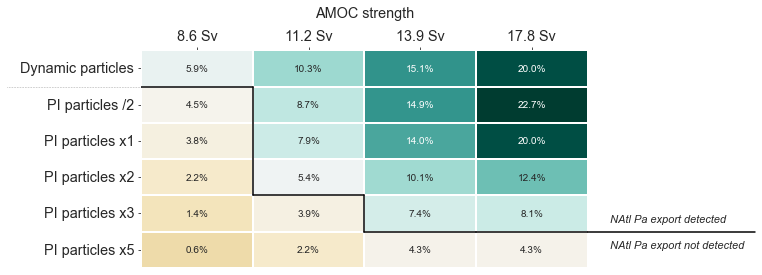

In [12]:
# PLOT HEATMAP

######## SETTINGS ##########################
add_text = False

# settings for thick black line
this_ls = 'solid'
this_lw = 1.5      # nicest: 1.5 or 1.0(and comment out dotted line below or adjust this_lw_dotted)
this_alpha = 1.0
############################################

fig, ax = plt.subplots(1, figsize=(8,4))

xlabels = ['8.6 Sv', '11.2 Sv', '13.9 Sv', '17.8 Sv']
ylabels = ['Dynamic particles','PI particles /2','PI particles x1','PI particles x2','PI particles x3','PI particles x5']

ax = sns.heatmap(detectability_perc_2d_array, cmap='BrBG', center=5, robust=True, linewidths=2,
                 xticklabels=xlabels, yticklabels=ylabels, cbar=False, vmin=0, 
                 cbar_kws={'extend' : 'max', 'ticks' : [0,5,10,15,20], 'format' : '%.0f%%'}, 
                 annot=detectability_perc_2d_array_str, fmt="")  # without %: annot=True, fmt=".1f", 
ax.xaxis.tick_top()
ax.set_title('AMOC strength', pad=12)

# plot dotted line between text on LHS
this_lw_dotted = 0.6  # 0.6 or 1.0
line = matplotlib.lines.Line2D([-1.2, 0], [1,1], lw=this_lw_dotted, color='grey', ls='dotted')
line.set_clip_on(False)
ax.add_line(line)

## add black boundary between detectability treshold at 5% ('like stairs')
[[xmin, xmax], [ymin, ymax]] = [ax.get_xlim(), ax.get_ylim()]
dx = (xmax - xmin)/4  # width of 1 column; there are 4 columns
dy = (ymax - ymin)/6  # width of 1 row

# horizontal line segments, from top to bottom
ax.plot([xmin, xmin+dx], [ymax-dy, ymax-dy], c='k', ls=this_ls, lw=this_lw, alpha=this_alpha)
ax.plot([xmin+dx, xmin+2*dx], [ymax-4*dy, ymax-4*dy], c='k', ls=this_ls, lw=this_lw, alpha=this_alpha)
ax.plot([xmin+2*dx, xmin+3*dx], [ymax-5*dy, ymax-5*dy], c='k', ls=this_ls, lw=this_lw, alpha=this_alpha)
ax.plot([xmin+3*dx, xmin+4*dx], [ymax-5*dy, ymax-5*dy], c='k', ls=this_ls, lw=this_lw, alpha=this_alpha)
# vertical line segments, from left to right
ax.plot([xmin+dx, xmin+dx], [ymax-dy, ymax-4*dy], c='k', ls=this_ls, lw=this_lw, alpha=this_alpha)
ax.plot([xmin+2*dx, xmin+2*dx], [ymax-4*dy, ymax-5*dy], c='k', ls=this_ls, lw=this_lw, alpha=this_alpha)

if add_text:
   ## add clarifying text (optional)
   # extend last line segment; with other method because outside plotting area
   line = matplotlib.lines.Line2D([4.0, 5.5], [5,5], color='k', ls=this_ls, lw=this_lw, alpha=this_alpha)
   line.set_clip_on(False)
   ax.add_line(line)
   # add text
   kwargs = {'size' : 11, 'fontstyle' : 'italic'}
   ax.text(1.05, 0.21, 'NAtl Pa export detected', kwargs, transform=ax.transAxes)
   ax.text(1.05, 0.09, 'NAtl Pa export not detected', kwargs, transform=ax.transAxes)

plt.savefig(savedir / 'fig8_heatmap_export_difference.pdf')

# Fig. 9: sketch expected profiles

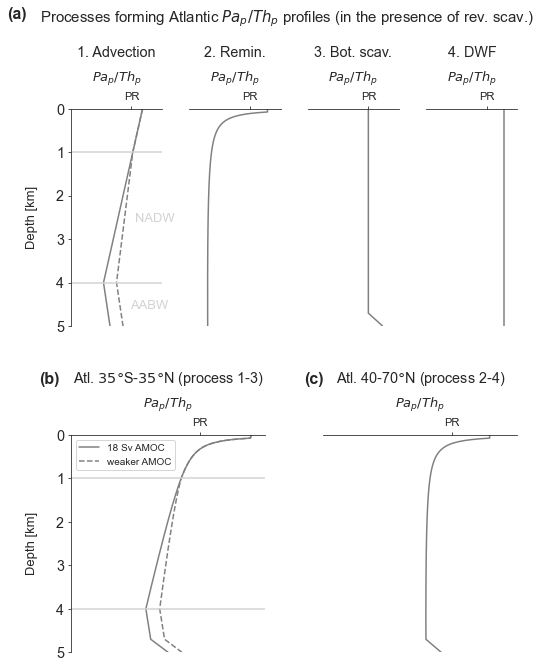

In [39]:
## SKETCH FIGURE

####### SETTINGS ############################################
col = 'gray'  # colour of graphs e.g. black or gray
# space between the 2 gridspecs
margin = 0.5
# padding between subplots within 1 nested gridspec
padding = 0.3
# process 1:
depth_NADW_start = 1.0  # km
depth_NADW_end = 4.0    # 4 is realistic but lower in model
# process 3:
depth_neph_start = 4.7  # km
# panel (b), (c): divide by arbitrary number s.t. fits:
div_scale = 2
######## END OF SETTINGS #####################################

#### CREATE FIGURE SUBPLOTS ####
fig = plt.figure(figsize=(8,10))
fig.suptitle("Processes forming Atlantic $Pa_p/Th_p$ profiles (in the presence of rev. scav.)", y=1.02, fontsize=15)

## we use nested gridspecs:
# gs0 contains all
gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1,1], 
                        wspace=margin, hspace=margin)

# gs_processes on upper left; contains 1x4 process sketches
gs_processes = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[0],
                                                wspace=padding, hspace=padding)

# gs_profile_sketches on lower row => constains 1x2 profile sketches
gs_profiles = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1],
                                               wspace=padding, hspace=padding)

## gridspec info:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html#sphx-glr-gallery-subplots-axes-and-figures-gridspec-nested-py
# https://matplotlib.org/stable/gallery/userdemo/demo_gridspec03.html
# https://stackoverflow.com/questions/22511550/gridspec-with-shared-axes-in-python

# create subplots inside the 2 gridspecs
[ax_process1,ax_process2,ax_process3,ax_process4] = gs_processes.subplots(sharex='row', sharey='col')
[ax_atl, ax_atl_dwf] = gs_profiles.subplots(sharex='row')

#### TITLES, LABELS, TICKS ####
title_pad = 13.0
# process 0. Reversible scavenging + particle sinking = omitted 
# => process 0 is always present, otherwise nothing happens (Pa/Th would always stay at PR)
#    constant depth profile based on Bacon et al. 1982 Journal of Geophysical Research (their model III)
#    this is confirmed by constant 0.093 Pap/Thp throughout run with no circulation
ax_process1.set_title("1. Advection", pad=title_pad)   # 1. Horizontal advection
ax_process2.set_title("2. Remin.", pad=title_pad)      # 2. Production + remineralization
ax_process3.set_title("3. Bot. scav.", pad=title_pad)  # 3. Bottom scavenging
ax_process4.set_title("4. DWF", pad=title_pad)         # 4. Deep Water Formation
# process 5. Vertical diffusion of Pa, Th = omitted (counteracts vertical gradient somewhat)
ax_atl.set_title("Atl. $35\degree$S-$35\degree$N (process 1-3)", pad=title_pad)
ax_atl_dwf.set_title("Atl. 40-70$\degree$N (process 2-4)", pad=title_pad)

## all subplots
for axis in [ax_process1, ax_process2, ax_process3, ax_process4, ax_atl, ax_atl_dwf]:
    # limits, ticks & invert yaxis
    axis.set_xlim(0,0.14)  # such that 0.093 is inside; now too often (x axis is shared)
    axis.set_ylim(0,5)
    axis.invert_yaxis()
    axis.set_xticks([0.093])
    axis.set_xticklabels(["PR"], fontsize=11)
    axis.set_xlabel("$Pa_p/Th_p$", fontsize=13, labelpad=10.0)
    axis.set_yticks([])
    # hide bottom and right axes legs
    axis.spines[['right', 'bottom']].set_visible(False)
    # move xticks to upper axis
    axis.xaxis.set_label_position('top')
    axis.xaxis.set_ticks_position('top')

## left subplots: yticks & ylabel
for axis in [ax_process1, ax_atl]:
    axis.set_ylabel("Depth [km]\n", fontsize=13)
    axis.set_yticks(list(np.arange(5,-1,-1)))  # overwrite empty ticks

## middle and right subplots: hide y axis
for axis in [ax_process2, ax_process3, ax_process4, ax_atl_dwf]:
    axis.spines[['left']].set_visible(False)

# annotate (a), (b), (c)
## This setting looks good in the pdf (not in the preview here)
ax_process1.text(-0.7, 1.413, '(a)', transform=ax_process1.transAxes, 
                size=16, weight='bold')
ax_atl.text(-0.163, 1.233, '(b)', transform=ax_atl.transAxes, 
            size=16, weight='bold')
ax_atl_dwf.text(-0.10, 1.233, '(c)', transform=ax_atl_dwf.transAxes, 
                size=16, weight='bold')
## This setting looks good in the preview here, but not in the pdf
# ax_process1.text(-0.8, 1.403, '(a)', transform=ax_process1.transAxes, 
#                 size=16, weight='bold')
# ax_atl.text(-0.19, 1.255, '(b)', transform=ax_atl.transAxes, 
#             size=16, weight='bold')
# ax_atl_dwf.text(-0.17, 1.255, '(c)', transform=ax_atl_dwf.transAxes, 
#                 size=16, weight='bold')

#### PLOT PROCESSES ####

# process 1. Horizontal advection
Z_adv = [0,depth_NADW_start,depth_NADW_end,5]
# new with smaller slope:
Y_adv = [0.11, 0.095, 0.05, 0.06]  # such that slope stays the same between gyre and NADW
Y_adv_weak = [0.11, 0.095, 0.07, 0.08]
# original with very visible slope:
# Y_adv = [0.13, 0.10, 0.01, 0.02]  # such that slope stays the same between gyre and NADW
# Y_adv_weak = [0.13, 0.10, 0.05, 0.06]
ax_process1.plot(Y_adv, Z_adv, c=col, label='18 Sv AMOC', ls='solid')
## Equivalent:
# Z_adv_hires, Y_adv_hires = f.interpolate_linear_segments(Z_adv, Y_adv, 5000)
# ax_process1.plot(Y_adv_hires, Z_adv_hires, c=col)
ax_process1.plot(Y_adv_weak, Z_adv, c=col, label='weaker AMOC', ls='dashed')
ax_process1.text(0.7, 0.48, 'NADW', transform=ax_process1.transAxes, size=13, c='lightgray')
ax_process1.text(0.65, 0.08, 'AABW', transform=ax_process1.transAxes, size=13, c='lightgray')
ax_process1.plot([0,0.14], [depth_NADW_start,depth_NADW_start], c='lightgray')
ax_process1.plot([0,0.14], [depth_NADW_end,depth_NADW_end], c='lightgray')
# ax_process1.legend(loc='upper right', fontsize=8)

# process 2. Remineralization + Production (determines the z=75m value; arbitrary in this sketch)
# in the CTRL Atl north of 35S: Pa is clearly dominated by POC and Th clearly by CaCO3
# so we approximate and then divide effects on both => shape is R_POC(z) / R_ca(z)
def R_poc(z):
    return (z/0.075)**(-0.83)  # z in km
def R_ca(z):
    return math.exp(-(z-0.075)/5.066)  # z in km
Z_remin = np.asarray(np.arange(0.001,5,0.001))
Y_remin = [min(1, R_poc(z) / R_ca(z)) for z in Z_remin]  
# manually add the z=0 (R_ca(z)=inf when computed):
Z_remin = np.concatenate([[0], Z_remin])
Y_remin = np.concatenate([[Y_remin[0]], Y_remin])
Y_remin = 0.02 + Y_remin * 0.1  # play around to make it fit nicely
# Y_remin = Y_remin * 0.12     # less steep; closer to 0
ax_process2.plot(Y_remin, Z_remin, c=col) 

# process 3. Bottom scavenging by nepheloid layers
Z_neph = [0, depth_neph_start, 5]
Y_neph = [0.093, 0.093, 0.115]
ax_process3.plot(Y_neph, Z_neph, c=col)

# process 4. Deep Water Formation
Z_dwf = [0, 5]
Y_dwf = [0.12, 0.12]
ax_process4.plot(Y_dwf, Z_dwf, c=col)

# process 5. Vertical diffusion of Pa, Th = omitted (counteracts vertical gradient somewhat)

#### PLOT TOTAL PROFILES ####

# prepare: convert linear segments of process 1 and 3 to arrays with many data points (high resolution)
Z_adv_hires, Y_adv_hires = f.interpolate_linear_segments(Z_adv, Y_adv, 5000)
Z_adv_hires_weak, Y_adv_hires_weak = f.interpolate_linear_segments(Z_adv, Y_adv_weak, 5000)
Z_neph_hires, Y_neph_hires = f.interpolate_linear_segments(Z_neph, Y_neph, 5000)

assert len(Z_remin) == len(Z_adv_hires) == len(Z_neph_hires), "needs same Z axes length"
assert abs(Z_remin[0]-Z_adv_hires[0]) < 1e-8 and abs(Z_remin[0]-Z_neph_hires[0]) < 1e-8, "needs same Z axes start"
assert abs(Z_remin[-1]-Z_adv_hires[-1]) < 1e-8 and abs(Z_remin[-1]-Z_neph_hires[-1]) < 1e-8, "needs same Z axes end"

## mid-latitudes and EQ region: adding shape of processes 1-3
Y00 = 0.13 + (Y_adv_hires-Y_adv_hires[0] + Y_remin-Y_remin[0] + Y_neph_hires-Y_neph_hires[0]) / div_scale
Y00_weak = 0.13 + (Y_adv_hires_weak-Y_adv_hires_weak[0] + Y_remin-Y_remin[0] + Y_neph_hires-Y_neph_hires[0]) / div_scale
ax_atl.plot(Y00, Z_remin, c=col, label='18 Sv AMOC', ls='solid')
ax_atl.plot(Y00_weak, Z_remin, c=col, label='weaker AMOC', ls='dashed')

ax_atl.legend(fontsize=10, borderpad=0.35)


ax_atl.plot([0,0.14], [depth_NADW_start,depth_NADW_start], c='lightgray')
ax_atl.plot([0,0.14], [depth_NADW_end,depth_NADW_end], c='lightgray')

## DWF region: combining processes 2-4
# adding shape of 2-4 (4 changes nothing):
Y10 = 0.12 + (Y_remin-Y_remin[0] + Y_neph_hires-Y_neph_hires[0]) / div_scale
ax_atl_dwf.plot(Y10, Z_remin, c=col, label='18 Sv AMOC', ls='solid')

plt.savefig(savedir / 'fig9_sketch_profiles.pdf')

# Fig. 3b, 10, 12, C5: depth profiles per region

Take a few regions in the West Atlantic, in the deep part in the direction of the Mid-Atlantic Ridge (but not there yet). And in regions where observations presents. The notes below are summarized in the regions dict:
- NE of Bermuda Rise in direction of MAR: 24-25 by 33-35 (OR 34-35)
  - includes 2 sw data and 2 sediment
- Bermuda Rise: 21-23 (OR 21-22 OR 22-23) by 30-31 
  - includes 1 sw and 1 sed
  - NB: Bermuda Rise region is 32-36N and -66 to -57 E; in grid cells this would be 30-31 by 21-22 so 2x2
- Carra (?) Rise (Venezuela in direction of MAR): 22-24 by 26-27
  - includes 1 sw data point and 2 clusters of sediment.
- off northern Brasil: 24-25 by 21-23
  - includes 3 sediment cores + 1 cluster of sediment cores
- off southern Brasil: 26-27 by 14-16
  - includes 2 sw data points + just outside of 1 sediment core  

In [40]:
######### SETTINGS FOR ALL PLOTS BELOW #####################
# Define small regions of interest in the Atlantic; 
# just 4-6 water columns s.t. not drawing conclusions from 1 water column/grid cell
# form: [[lon_start, lon_end],[lat_start,lat_end]] with indices as Bern3D map i.e. starting from 1
regions = {1: [[25,26], [31,33]], # NE of Bermuda Rise / south of GRL
           2: [[20,22], [28,30]],  # Bermuda Rise
           3: [[23,25], [20,25]],  # off Venezuela & northern Brasil
           4: [[24,26], [13,16]],  # off southern Brasil
           }

colors_AMOC = ['k'] + list(cmp.Blues_r([0.1, 0.55, 0.85 ]))  # used in Fig. 10
ls_AMOC = ['solid', 'dashdot', 'dashed', 'solid']            # linestyles in Fig. 10
labels_AMOC = ['17.8 Sv', '14 Sv', '11 Sv', '8.6 Sv']
########################################
assert len(colors_AMOC) == len(labels_AMOC), "colors_AMOC and labels_AMOC must have same length"
assert len(ls_AMOC) == len(labels_AMOC), "ls_AMOC and labels_AMOC must have same length"

### Fig. 3b: regions map 
Is combined with panel a in fig3ab_map.pptx

regions setting: {1: [[25, 26], [31, 33]], 2: [[20, 22], [28, 30]], 3: [[23, 25], [20, 25]], 4: [[24, 26], [13, 16]]} 

Region 1 is  321.5 - 328.5 lon and 37.5 - 47.5 N (T-grid)
Region 2 is  286.0 - 300.5 lon and 22.5 - 32.5 N (T-grid)
Region 3 is  307.5 - 321.5 lon and -4.5 - 10.5 N (T-grid)
Region 4 is  314.5 - 328.5 lon and -32.5 - -17.5 N (T-grid)




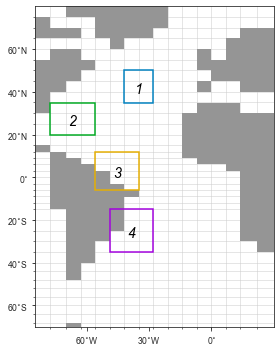

In [41]:
fig, ax = plt.subplots(1,1, figsize=(4,5))

ax = f.plot_regions_map(ax, data_fulls[runs[0]], regions=regions,  # 'regions' could be omitted as default has same regions
                        verbose=True, lw=1.5, Bern3D_grid=True,
                        colors=['#0082c1', '#00ab23', '#e6af02', '#a300df'])  # color regions as in Fig. 3a
                        # colors=['k'] * 4)                                   # color regions black
ax.set_title("")

# set domain & yticks equal to Fig. 3a (map of cores):
ax.set_xlim(275,390)  # domain [85W, 30E] is [275,390] in Bern3D coordinates
ax.set_ylim(-70,80)
ax.set_yticks(range(-60,70,20))

# add '°W' etc
ax = f.convert_ticks_of_map(ax, Bern3D_grid=True, font="Arial")

# smaller ticklabels
ax.tick_params(axis='x', labelsize=8.5)
ax.tick_params(axis='y', labelsize=8.5)

plt.tight_layout()
plt.savefig(savedir / ('fig3b_regions_map.pdf'))

### Fig. 10

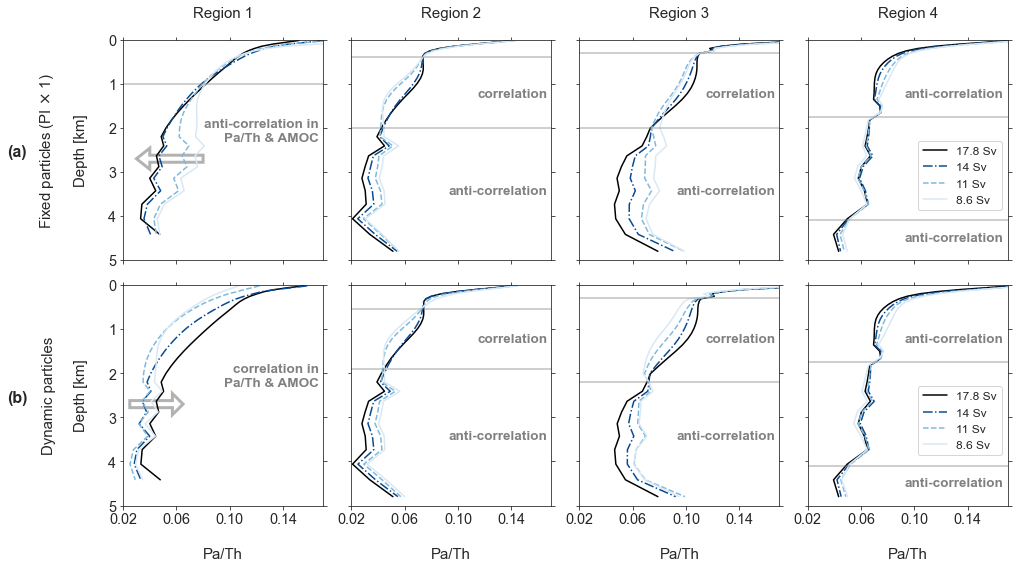

In [42]:
# plot of Pap/Thp vs. depth per region 
# VERSION: Row 1 fixed particles; row 2 dynamic particles; without observations

######### SETTINGS #####################
anom = False      # w.r.t. surface value
zoom = False     # cut off first km; for better visibility / interpretation
c_obs = 'k'
ymax = 5.0      # km
annotate = True  # indicate regimes of (anti-)correlation between Pa/Th and AMOC
row_labels = [r'Fixed particles (PI $\times$ 1)', 'Dynamic particles']
## version with only CTRL:
# runs_per_row = [[particles_ctrl_yesneph],
#                 [best_3P5_ctrl]]  # ALSO ADJUST row_labels!
## version with all AMOCs (as in manuscript):
runs_per_row = [[particles_ctrl_yesneph, PFX1__14SV, PFX1__11SV, PFX1__09SV], 
                [best_3P5_ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV]]  # ALSO ADJUST row_labels!
########################################
assert len(row_labels) == len(runs_per_row), "Labels of subplot must have same length as runs_per_subplot"
assert not (anom and zoom), "Combining anom and zoom is not useful"
if annotate:
    assert not(anom or zoom), "Cannot combine annotate with anom or zoom"

# preparations
model_lon = data_fulls[runs[0]].lon_t.values
model_lat = data_fulls[runs[0]].lat_t.values

# start figure
fig, ax = plt.subplots(len(row_labels), 4, figsize=(14, 4*len(row_labels)))  # 4 cols because 4 regions

for row in range(len(row_labels)):
    ax[row,0].set_ylabel(row_labels[row] + "\n\nDepth [km]\n", fontsize=15)
    for region_nr, [lons,lats] in regions.items():
        assert len(lons) == 2 and len(lats) == 2, "lons and lats of regions dict need to have length 2"
        col = region_nr-1
        
        for n,run in enumerate(runs_per_row[row]):
            # slice model result of this run to region:
            # lon_start-1 to convert to python index; lon_end-1 +1 as [] excludes last
            model_region = data_fulls[run].isel(time=t, lon_t=slice(lons[0]-1,lons[1]), 
                                                lat_t=slice(lats[0]-1,lats[1]))

            plot_obj = f.area_mean(data_fulls[run], model_region['path_ratio_p'])
            if anom:
                ax[row,col].plot(plot_obj.values-plot_obj.values[0], plot_obj.z_t, 
                                 c=colors_AMOC[n], ls=ls_AMOC[n], label=labels_AMOC[n])
            else:
                ax[row,col].plot(plot_obj.values, plot_obj.z_t, 
                                 c=colors_AMOC[n], ls=ls_AMOC[n], label=labels_AMOC[n])

        if zoom:
            ax[row,col].set_ylim(1,ymax)
            ax[row,col].set_yticks(range(1,6))
        else:
            ax[row,col].set_ylim(0,ymax)
            ax[row,col].set_yticks(range(0,6))
        ax[row,col].invert_yaxis()
        if anom:
            ax[row,col].set_xlim(-0.16,0.0)
            ax[row,col].set_xticks([-0.15, -0.1, -0.05, 0])
            ax[row,col].set_xticklabels(["-0.15", "-0.10", "-0.05", "0"])
        elif zoom:
            ax[row,col].set_xlim(0.02, 0.11)
            ax[row,col].set_xticks([0.02, 0.06, 0.10])
        else:
            ax[row,col].set_xlim(0.02, 0.17)
            ax[row,col].set_xticks(np.arange(0.02, 0.18, 0.04))

        if row == 0:
            ax[row,col].set_title("Region " + str(region_nr) + "\n", fontsize=15)
            ax[row,col].set_xticklabels([])
        else:
            if anom:
                ax[row,col].set_xlabel("\nPa/Th - Pa/Th[z=0]", fontsize=14)
            else:
                ax[row,col].set_xlabel("\nPa/Th", fontsize=15)
        if col != 0:
            ax[row,col].set_yticklabels([])

        ax[row,col].tick_params(axis='both', bottom=True, top=True, left=True, right=True)

ax[0,3].legend(loc='lower right', fontsize=12, bbox_to_anchor=(0.5, 0.2, 0.5, 0.5))
ax[1,3].legend(loc='lower right', fontsize=12, bbox_to_anchor=(0.5, 0.2, 0.5, 0.5))
for row in [0,1]:
    ax[row,0].text(-0.58, 0.47, '(' + chr(ord('a')+row) + ')', transform=ax[row,0].transAxes, 
                   size=16, weight='bold')

if annotate:
    kwargs = {'size' : 13.5, 'fontweight' : 'bold', 'c' : 'gray'}
    ra = 0.167  # right alignment boundary of text

    ### Region 1 manual
    ax[0,0] = f.add_line(ax[0,0], 1.0, c='grey', alpha=0.5) # line at 1 km
    ax[0,0].text(ra, 2.3, 'anti-correlation in\nPa/Th & AMOC', kwargs, ha='right')
    ax[1,0].text(ra, 2.3, 'correlation in\nPa/Th & AMOC', kwargs, ha='right')
    
    #### Region 2-4 in for loop
    ## horizontal lines at depths where CTRL and weak AMOC runs intersect
    # (ax_object) : [km_lines]
    hor_lines_per_ax = {(0,1):[0.4, 2.0], (0,2):[0.3, 2.0], (0,3):[1.75, 4.1], 
                        (1,1):[0.55, 1.9], (1,2):[0.3, 2.2], (1,3):[1.75, 4.1]}
    ## text 'correlation' or 'anti-correlation'                   
    # (ax_object) : [x, y] of right-aligned text position 
    correlation_text_per_ax = {(0,1): [ra,1.3], (0,2): [ra,1.3], 
                               (1,1): [ra,1.3], (1,2): [ra,1.3]}
    anticorrelation_text_per_ax = {(0,1): [ra,3.5], (0,2): [ra,3.5], (0,3): [ra,1.3], 
                                   (1,1): [ra,3.5], (1,2): [ra,3.5], (1,3): [ra,1.3]}
    for row in [0,1]:
        for col in [1,2,3]:
            ax[row,col] = f.add_line(ax[row,col], hor_lines_per_ax[(row,col)], c='grey', alpha=0.5)
            if col != 3:  # no significant correlation in region 4; obj empty for those
                [x,y] = correlation_text_per_ax[row,col]
                ax[row,col].text(x,y, 'correlation', kwargs, ha='right')
            [x,y] = anticorrelation_text_per_ax[row,col]
            ax[row,col].text(x,y, 'anti-correlation', kwargs, ha='right')
    # manually add a 2nd anti-correlation text in region 4
    [x,y]=[ra,4.57]
    ax[0,3].text(x,y, 'anti-correlation', kwargs, ha='right')
    ax[1,3].text(x,y, 'anti-correlation', kwargs, ha='right')
    # add arrows
    arrow = matplotlib.patches.Arrow(x=0.08, y=2.7, dx=-0.05, dy=0, color=kwargs['c'], fill=False, 
                                     lw=3, alpha=0.6, width=0.8)
    ax[0,0].add_patch(arrow)
    arrow = matplotlib.patches.Arrow(x=0.025, y=2.7, dx=0.04, dy=0, color=kwargs['c'], fill=False, 
                                     lw=3, alpha=0.6, width=0.8)
    ax[1,0].add_patch(arrow)

plt.tight_layout()
if anom:
    plt.savefig(savedir / ('path_regions_fixed_dynamic_anom.pdf'))
elif zoom:
    plt.savefig(savedir / ('path_regions_fixed_dynamic_zoom.pdf'))
else:
    plt.savefig(savedir / ('fig10_path_regions_fixed_dynamic.pdf'))
    
# by design row 1 and 2 are practically identical for 17.8 Sv

### Fig. 12

For region 3 some sed obs are higher than xlim (max: 0.268 ).


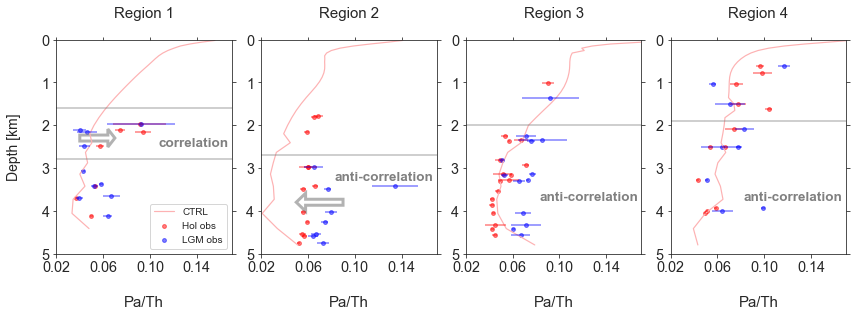

In [43]:
# plot of Pap/Thp vs. depth per region 
# VERSION: only 1 row, plotting both obs timeslices (for alternative Fig. 13) OR no obs (for Fig. 14)

######### SETTINGS #####################
anom = False    # w.r.t. surface value
zoom = False    # cut off first km; for work in progress / interpretation
ymax = 5.0      # km
size_obs = 15
alpha_obs = 0.5

both_obs = True  # Hol and LGM
annotate = True  # add grey text and lines with (anti-)correlation
c_obs = {'Hol' : 'red', 'LGM' : 'blue'}
# either all AMOCs
# row_labels = ['Dynamic particle runs with obs']
# runs_per_row = [[best_3P5_ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV]]
# these_colors = colors_AMOC
# # or CTRL only:
row_labels = ['']
runs_per_row = [[best_3P5_ctrl]]
# these_colors = ['red']    # because CTRL run represents Holocene (red)
these_colors = ['#fdb2b3']  # because CTRL run represents Holocene (light red)
these_linestyles = ['solid'] * len(runs_per_row[0])
these_labels = [labels[run] for run in runs_per_row[0]]

########################################
assert len(row_labels) == len(runs_per_row), "Labels of subplot must have same length as runs_per_subplot"

# preparations
model_lon = data_fulls[runs[0]].lon_t.values
model_lat = data_fulls[runs[0]].lat_t.values

if both_obs:
    # change index to have lon and lat only (i.e. no z)
    sed_obj = {}
    for timeslice_str in ['Hol', 'LGM']:
        sed_obj_tmp = obs_sed_model_grid[obs_sed_model_grid.age_ka == timeslice_str + '_avg']
        sed_obj_tmp = sed_obj_tmp.reset_index().set_index(['lon_sim_100_to_460','lat_sim'])
        sed_obj_tmp.sort_index(inplace=True)
        sed_obj[timeslice_str] = sed_obj_tmp

# start figure
if anom:
    fig, ax = plt.subplots(1, 5, figsize=(12.5, 5))  # 5 cols because 4 regions + 1 map
    if both_obs:
        raise Exception("Not implemented anom & both_obs yet.")
    if zoom:
        raise Exception("Not implemented anom & zoom yet.")
else:
    fig, ax = plt.subplots(1, 4, figsize=(12, 4.5))  # 4 cols because 4 regions
    
row = 0
if row_labels[row] == "":  # default setting (empty label)
    ax[0].set_ylabel("Depth [km]\n", fontsize=14)
else:
    ax[0].set_ylabel(row_labels[row] + "\n\nDepth [km]\n", fontsize=14)

for region_nr, [lons,lats] in regions.items():
    assert len(lons) == 2 and len(lats) == 2, "lons and lats of regions dict need to have length 2"
    col = region_nr-1

    for n,run in enumerate(runs_per_row[row]):
        # slice model result of this run to region:
        # lon_start-1 to convert to python index; lon_end-1 +1 as [] excludes last
        model_region = data_fulls[run].isel(time=t, lon_t=slice(lons[0]-1,lons[1]), 
                                            lat_t=slice(lats[0]-1,lats[1]))

        plot_obj = f.area_mean(data_fulls[run], model_region['path_ratio_p'])
        if anom:
            ax[col].plot(plot_obj.values-plot_obj.values[0], plot_obj.z_t, c=these_colors[n], 
                         label=these_labels[n], ls=these_linestyles[n], alpha=1.0)
            ax[col].scatter(0, plot_obj.z_t[0], c='k', s=30, clip_on=False) # add dot at surface data point
        else:
            ax[col].plot(plot_obj.values, plot_obj.z_t, c=these_colors[n], 
                        label=these_labels[n], ls=these_linestyles[n], alpha=1.0, lw=1.2)
            if not both_obs:
                ax[col].scatter(plot_obj.values[0], plot_obj.z_t[0], c=these_colors[n], 
                s=30, clip_on=False)   # add dot at surface data point
    if both_obs:
        for timeslice_str in ['Hol', 'LGM']:
            ## SEDIMENT OBS. OF PAP/THP
            # slice obs to region (sometimes result is empty)
            # -1 to convert to python indices
            obs_sed_region = sed_obj[timeslice_str].loc[(slice(model_lon[lons[0]-1],model_lon[lons[1]-1]),
                                                        slice(model_lat[lats[0]-1],model_lat[lats[1]-1])), :]
            nr_cores_region = len(obs_sed_region.index)

            # plot observations
            # loop over sediment cores
            if nr_cores_region > 0:
                max_obs = obs_sed_region.path_ratio_p.max()
                if max_obs > 0.17:
                    print('For region', region_nr, 'some sed obs are higher than xlim (max:', 
                            round(max_obs,3), ').')

                for i,(lon,lat) in enumerate(np.unique(obs_sed_region.index)):
                    # it is possible that 1 water column has sed cores at multiple z
                    plot_obj = obs_sed_region.loc[lon,lat]
                    x = plot_obj['path_ratio_p'].astype('float')
                    y = plot_obj.z / 1000
                    assert y.max() < ymax, "Obs at "+str(y.max())+" lies below ymax."
                    if i == 0:
                        ax[col].scatter(x, y, c=c_obs[timeslice_str], s=size_obs, alpha=alpha_obs,
                                        label=timeslice_str + ' obs')
                    else:
                        ax[col].scatter(x, y, c=c_obs[timeslice_str], s=size_obs, alpha=alpha_obs)
                    ax[col].errorbar(x, y, xerr=plot_obj['path_ratio_p_err'], fmt='none',
                                     c=c_obs[timeslice_str], alpha=alpha_obs)

    if zoom:
        ax[col].set_ylim(1,ymax)
        ax[col].set_yticks(range(1,6))
        ax[col].invert_yaxis()
    else:
        ax[col].set_ylim(0,ymax)
        ax[col].set_yticks(range(0,6))
        ax[col].invert_yaxis()
    if anom:
        ax[col].set_xlim(-0.2,0.02)
        ax[col].set_xticks([-0.2, -0.1, 0])
        ax[col].set_xlabel("\nPa/Th - Pa/Th[z=0]", fontsize=15)
    else:
        if zoom:
            ax[col].set_xlim(0.03, 0.13)  # does NOT corresponds to max_obs print statement check above
        else:
            ax[col].set_xlim(0.02, 0.17)  # corresponds to max_obs print statement check above
        ax[col].set_xticks(np.arange(0.02, 0.18, 0.04))
        ax[col].set_xlabel("\nPa/Th", fontsize=15)

    ax[col].tick_params(axis='both', bottom=True, top=True, left=True, right=True)

    ax[col].set_title("Region " + str(region_nr) + "\n", fontsize=15)

ax[0].legend(loc='lower right', fontsize=10) # fontsize=12)
# add row titles on LHS
# ax[0].text(-0.6, 0.05, row_labels[0], size=14, rotation=90, transform=ax[0].transAxes, ha='center')

if annotate:
    kwargs = {'size' : 13.5, 'fontweight' : 'bold', 'c' : 'gray'}
    # kwargs = {'size' : 17, 'fontweight' : 'normal', 'c' : 'gray'}
    ra = 0.167  # right alignment boundary of text
    ## horizontal lines at depths where CTRL and weak AMOC runs intersect
    # (ax_object) : [km_lines]
    hor_lines_per_ax = {(0):[1.6,2.8], (1):[2.7], (2):[2.0], (3):[1.9]}
    ## text 'correlation' or 'anti-correlation'                   
    # (ax_object) : [x, y] of right-aligned text position 
    correlation_text_per_ax = {(0): [ra,2.5]}
    anticorrelation_text_per_ax = {(1): [ra,3.28], (2): [ra,3.75], (3): [ra,3.75]}

    for col in hor_lines_per_ax:
        ax[col] = f.add_line(ax[col], hor_lines_per_ax[(col)], c='grey', alpha=0.5)
    for col in correlation_text_per_ax:
        [x,y] = correlation_text_per_ax[col]
        ax[col].text(x,y, 'correlation', kwargs, ha='right')
    for col in anticorrelation_text_per_ax:
        [x,y] = anticorrelation_text_per_ax[col]
        ax[col].text(x,y, 'anti-correlation', kwargs, ha='right')

    # add arrows
    arrow = matplotlib.patches.Arrow(x=0.04, y=2.3, dx=0.03, dy=0, color=kwargs['c'], fill=False, 
                                     lw=3, alpha=0.6, width=0.7)
    ax[0].add_patch(arrow)
    arrow = matplotlib.patches.Arrow(x=0.09, y=3.8, dx=-0.04, dy=0, color=kwargs['c'], fill=False, 
                                     lw=3, alpha=0.6, width=0.7)
    ax[1].add_patch(arrow)

plt.tight_layout()
extra_info = ''
if anom:
    extra_info += '_anom'
if zoom:
    extra_info += '_zoom'
plt.savefig(savedir / ('fig12_path_regions_HolLGM_1row' + extra_info + '.pdf'))

**Export cores used to excel (to check which cores are in the figure)**

In [31]:
# Export sediment cores used in the figure above to excel

export_cores_used = {}

## define function
def save_xls(dict_df, path, with_index=True):
    """Save a dictionary of dataframes to an excel file, 
    with each dataframe as a separate sheet.
    # src: https://stackoverflow.com/questions/14225676/save-list-of-dataframes-to-multisheet-excel-spreadsheet
    """

    from pandas import ExcelWriter

    writer = ExcelWriter(path)
    for key in dict_df.keys():
        dict_df[key].to_excel(writer, sheet_name=key, index=with_index)

    writer.save()

## fill export_cores_used
model_lon = data_fulls[runs[0]].lon_t.values
model_lat = data_fulls[runs[0]].lat_t.values
for timeslice_str in ['Hol', 'LGM']:
   for region_nr, [lons,lats] in regions.items():
        # copied what is done from plot above
        obs_sed_region = sed_obj[timeslice_str].loc[(slice(model_lon[lons[0]-1],model_lon[lons[1]-1]),
                                                    slice(model_lat[lats[0]-1],model_lat[lats[1]-1])), :].copy()

        # edit columns before write-out
        obs_sed_region.reset_index(inplace=True) # make index into normal columns
        if '%opal' in obs_sed_region.columns:          
            # then clean data obs_sed was loaded
            obs_sed_region.drop(['lon_sim_0_to_360', 'lon_0_360', '# of data points  0-24 ka'], 
                                axis=1, inplace=True)
        elif 'lat_region' in obs_sed_region.columns:  
            # then dirty (more) data obs_sed was loaded
            obs_sed_region.drop(['lon_sim_0_to_360', 'lon_0_360', 'lat_region'], 
                                axis=1, inplace=True)
        
        # rearrange column order
        old_len = len(obs_sed_region.columns)
        column_order = list(range(0,6))+[old_len-1]+list(range(6,old_len-1))  # send last column 'delta_z' to col 6
        obs_sed_region = obs_sed_region[obs_sed_region.columns[column_order]]
        assert len(obs_sed_region.columns) == old_len, "ERROR: some columns disappeared"

        # save to dict export_cores_used
        export_cores_used[timeslice_str + '_' + 'region_' + str(region_nr)] = obs_sed_region

## save dict to excel without index (is now just numbers)
save_xls(dict_df=export_cores_used, path=savedir / 'sed_cores_used.xlsx', with_index=False)

# IT WORKS DESPITE WARNING

<ipython-input-31-3ebd1d53020b>:18: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


### Fig. C5: all model water columns  
Comparing a Pap/Thp from a model cell in the middle of a water column to sedimentary measured Pap/Thp is unfair, because the latter by definition experiences the strongest bottom scavenging of that water column. This plot illustrates this

TIMESLICE of obs: Hol
For region 3 some sed obs are higher than xlim (max: 0.268 ).
regions setting: {1: [[25, 26], [31, 33]], 2: [[20, 22], [28, 30]], 3: [[23, 25], [20, 25]], 4: [[24, 26], [13, 16]]} 

Region 1 is  321.5 - 328.5 lon and 37.5 - 47.5 N (T-grid)
Region 2 is  286.0 - 300.5 lon and 22.5 - 32.5 N (T-grid)
Region 3 is  307.5 - 321.5 lon and -4.5 - 10.5 N (T-grid)
Region 4 is  314.5 - 328.5 lon and -32.5 - -17.5 N (T-grid)




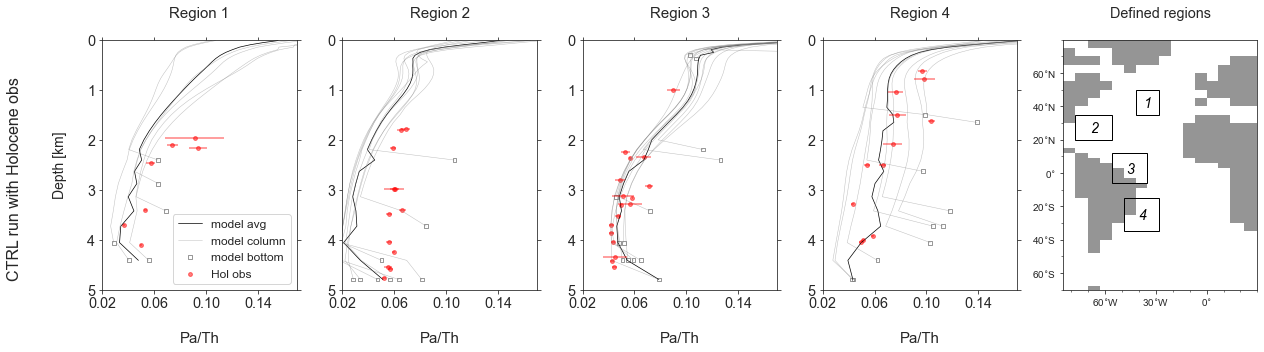

In [44]:
# plot of Pap/Thp vs. depth per region 
# VERSION: all grid cells of a region to see model-data difference

######### SETTINGS ###############################################################
runs_per_row = [[best_3P5_ctrl]]             # ALSO ADJUST row_labels
row_labels = ['CTRL run with Holocene obs']

obs = True
size_obs = 15
bottom_squares = True   # add square markers at bottom grid cell
timeslice_str = 'Hol'
c_obs = 'red'
alpha_obs = 0.5
run_color_avg = 'k'
run_color_column = 'grey'
alpha_column = 0.5
ymax = 5.0      # km
##################################################################################
print("TIMESLICE of obs:", timeslice_str)
assert len(row_labels) == len(runs_per_row), "Labels of subplot must have same length as runs_per_subplot"

# preparations
model_lon = data_fulls[runs[0]].lon_t.values
model_lat = data_fulls[runs[0]].lat_t.values
if obs:
    # change index to have lon and lat only (i.e. no z)
    sed_obj = obs_sed_model_grid[obs_sed_model_grid.age_ka == timeslice_str + '_avg']
    sed_obj = sed_obj.reset_index().set_index(['lon_sim_100_to_460','lat_sim'])
    meas_str = 'sed cores'
    sed_obj.sort_index(inplace=True)

# start figure
fig, ax = plt.subplots(1, 5, figsize=(17.5, 5))

row = 0
ax[0].set_ylabel("Depth [km]\n", fontsize=14)  # row_labels[row] is annotated at bottom
for region_nr, [lons,lats] in regions.items():
    assert len(lons) == 2 and len(lats) == 2, "lons and lats of regions dict need to have length 2"
    col = region_nr-1

    for n,run in enumerate(runs_per_row[row]):
        # slice model result of this run to region:
        # lon_start-1 to convert to python index; lon_end-1 +1 as [] excludes last
        model_region = data_fulls[run].isel(time=t, lon_t=slice(lons[0]-1,lons[1]), 
                                            lat_t=slice(lats[0]-1,lats[1]))

        # also plot regional avg in thick line
        plot_obj = f.area_mean(data_fulls[run], model_region['path_ratio_p'])
        ax[col].plot(plot_obj.values, plot_obj.z_t, c=run_color_avg, label='model avg', lw=0.7)
        if not obs:
            ax[col].scatter(plot_obj.values[0], plot_obj.z_t[0], c=run_color_avg, 
                            s=30, clip_on=False) # add dot at surface data point

        # now plot each water column's profile in this region (instead of regional average) for testing
        for i,this_lon in enumerate(model_region.lon_t):
            for j,this_lat in enumerate(model_region.lat_t):
                plot_obj = model_region.path_ratio_p.sel(lat_t=this_lat, lon_t=this_lon)
                if i == 0 and j == 0:
                    ax[col].plot(plot_obj.values, plot_obj.z_t, c=run_color_column, alpha=alpha_column, lw=0.5, 
                                 label='model column')
                else:
                    ax[col].plot(plot_obj.values, plot_obj.z_t, c=run_color_column, alpha=alpha_column, lw=0.5)
                if not obs:
                    ax[col].scatter(plot_obj.values[0], plot_obj.z_t[0], c=run_color_column, 
                                    s=30, clip_on=False)  # add dot at surface data point
                if bottom_squares: 
                    # add squares at bottom
                    plot_obj = plot_obj.dropna(dim='z_t')  # otherwise all bottom squares come at 5 km
                    if len(plot_obj.values) > 0:
                        if i == 0 and j == 0:
                            ax[col].scatter(plot_obj.values[-1], plot_obj.z_t[-1],
                                            edgecolors=run_color_column, facecolors='None', marker='s',
                                            alpha=alpha_column+0.3, s=size_obs, clip_on=False, label='model bottom')
                        else:
                            ax[col].scatter(plot_obj.values[-1], plot_obj.z_t[-1], 
                                            edgecolors=run_color_column, facecolors='None', marker='s',
                                            alpha=alpha_column+0.3, s=size_obs, clip_on=False)

        if obs:
            # slice obs to region (sometimes result is empty)
            # -1 to convert to python indices
            obs_sed_region = sed_obj.loc[(slice(model_lon[lons[0]-1],model_lon[lons[1]-1]),
                                          slice(model_lat[lats[0]-1],model_lat[lats[1]-1])), :]
            nr_cores_region = len(obs_sed_region.index)

            # plot observations
            # loop over sediment cores
            if nr_cores_region > 0:
                max_obs = obs_sed_region.path_ratio_p.max()
                if max_obs > 0.17:
                    print('For region', region_nr, 'some sed obs are higher than xlim (max:', 
                          round(max_obs,3), ').')

                for i,(lon,lat) in enumerate(np.unique(obs_sed_region.index)):
                    # it is possible that 1 water column has sed cores at multiple z
                    plot_obj = obs_sed_region.loc[lon,lat]
                    x = plot_obj['path_ratio_p'].astype('float')
                    y = plot_obj.z / 1000
                    assert y.max() < ymax, "Obs at "+str(y.max())+" lies below ymax."
                    if i == 0:
                        ax[col].scatter(x, y, c=c_obs, s=size_obs, alpha=alpha_obs, label=timeslice_str + ' obs')
                    else:
                        ax[col].scatter(x, y, c=c_obs, s=size_obs, alpha=alpha_obs)
                    ax[col].errorbar(x, y, xerr=plot_obj['path_ratio_p_err'], fmt='none',
                                     c=c_obs, alpha=alpha_obs)

    ax[col].set_ylim(0,ymax)
    ax[col].set_yticks(range(0,6))
    ax[col].set_xlim(0.02, 0.17)  # corresponds to max_obs print statement check above
    ax[col].set_xticks(np.arange(0.02, 0.18, 0.04))
    ax[col].invert_yaxis()
    ax[col].set_title("Region " + str(region_nr) + "\n", fontsize=15)
    ax[col].set_xlabel("\nPa/Th", fontsize=15)
    ax[col].tick_params(axis='both', bottom=True, top=True, left=True, right=True)

ax[0].legend(fontsize=12)

# ADD MAP WITH RECTANGLES
ax[4] = f.plot_regions_map(ax[4], data_fulls[runs[0]], regions=regions, 
                           verbose=True, lw=1, colors=['k'] * 4,
                           Bern3D_grid=False)  # can enable grid lines (as in Fig. 3) with Bern3D_grid=True                           
ax[4].set_title('Defined regions\n') # overwrite to have extra enter

# set domain & yticks equal to Fig. 3:
ax[4].set_xlim(275,390)  # domain [85W, 30E] is [275,390] in Bern3D coordinates
ax[4].set_ylim(-70,80)
ax[4].set_yticks(range(-60,70,20))

# add '°W' etc
ax[4] = f.convert_ticks_of_map(ax[4], Bern3D_grid=True, font="Arial")

# ADD ROW TITLES ON LHS
ax[0].text(-0.45, 0.05, row_labels[0], size=16, rotation=90, transform=ax[0].transAxes, ha='center')

plt.tight_layout()
plt.savefig(savedir / ('figC5_path_regions_all_colls_'+timeslice_str+'_'+runs_per_row[0][0]+'.pdf'))

# Fig. S5-S7: assess model development via Atl. zonal avg

figure_nr: 6
VERSION A: seawater Pa_d, Th_d and seawater Pa_p / Th_p
timestep: t= -1 

Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.


Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
runs in order of rows:
n= 0 so runname= 3P5_CTRL__ and run label= CTRL @yr 5000 

n= 1 so runname= 3P5OPNDUST and run label= NO_DUST @yr 5000 



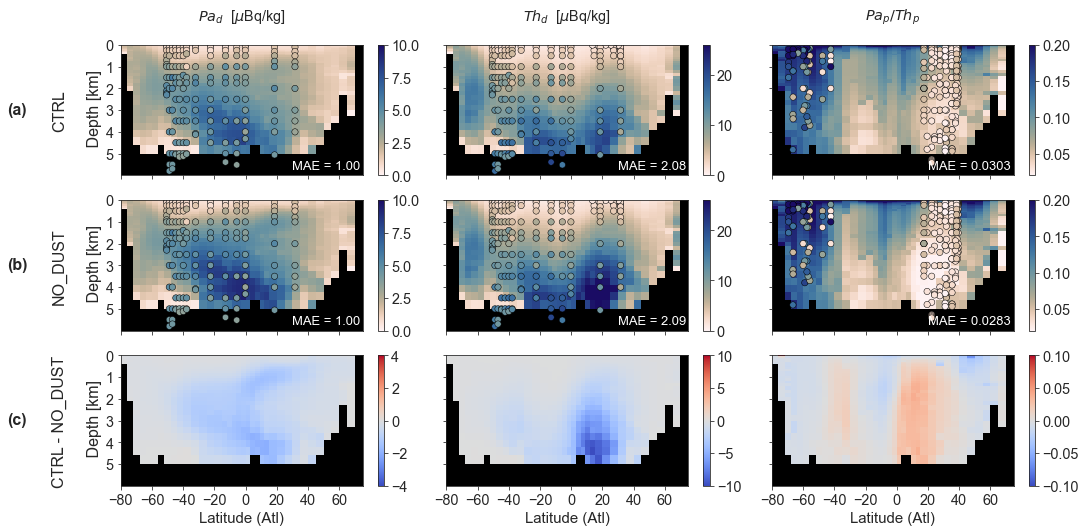

In [16]:
# zonal average in Atl for 2 runs + anomaly [optional]
# ===============================================================================
# VERSION A (AS IN MANUSCRIPT): 
# seawater Pa_d, Th_d (GA02 or entire Atl) and seawater Pa_p / Th_p (only GA03 and GIPY05)
# ===============================================================================

##################### SETTINGS ######################################################
figure_nr = 6          # choose from '5' (neph), '6' (dust), '7' (remineralization term)

obs = True
sw_entire_atl = False  # otherwise we only use GA02 (West Atl) sw data (as in paper)
anomaly = True         # add 3rd row with anomaly plot
anom_free = False      # overwrites anom_zoom_in
print_mae = True       # prints MAE in the panels; desired but slower
verbose = False         # also print MAEs as text as check
rectangular = True     # make figure broader; more suitable for 16:9 slides
cmap = cmcr.lapaz_r
t=-1                   # output time step to plot

# set colour scale boundaries:
vmins = {'Pad' : 0.0, 'Thd' : 0.0, 'Pap' : 0.0, 'Thp' : 0.0, 
         'path_ratio_d' : 0.0, 'path_ratio_p' : 0.02}
vmaxs = {'Pad' : 10, 'Thd' : 26, 'Pap' : 0.4, 'Thp' : 6, 
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}
# settings for vmaxs_anom are below, depending on which figure_nr
##################### END OF SETTINGS ###############################################
print('figure_nr:', figure_nr)
print('VERSION A: seawater Pa_d, Th_d and seawater Pa_p / Th_p')
print("timestep: t=",t, '\n')

# define runs to use
if figure_nr == 5:    # Fig. S5
    these_runs = [best_3P5_ctrl, best_3P5_noneph_sigmas]
    vmaxs_anom = {'Pad' : 8, 'Thd' : 20, 'path_ratio_p' : 0.1}
elif figure_nr == 6:  # Fig. S6
    these_runs = [best_3P5_ctrl, best_3P5_nodust]
    vmaxs_anom = {'Pad' : 4, 'Thd' : 10, 'path_ratio_p' : 0.1}
elif figure_nr == 7:  # Fig. S7
    these_runs = [best_3P5_ctrl, best_3P5_norem]
    vmaxs_anom = {'Pad' : 0.5, 'Thd' : 0.5, 'path_ratio_p' : 0.05}
else:
    # a general setting to play around with Atl zonal averages + anomalies of other runs
    # these_runs =   # NEED TO FILL IN RUNS HERE IF PLAYING AROUND
    vmaxs_anom = {'Pad' : 2, 'Thd' : 4, 'path_ratio_p' : 0.1}
assert figure_nr in [5,6,7], "need to set figure_nr to 5, 6 or 7 (for neph, dust resp. remineralization term)"
assert len(these_runs) > 1, "This plot needs more than 1 run"

# prepare seawater Pa_d, Th_d
if sw_entire_atl:
    [this_sw, this_sw_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises='all')
else:
    [this_sw, this_sw_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises=['GA02', 'GAc02'])

# prepare seawater Pap/Thp
this_obs_p = obs_p.where(obs_p.path_ratio_p.notnull()).dropna(how='all')      # keep only obs with ratio
# add uncertainty of ration via error propagation for division
this_obs_p['path_ratio_p_err'] = this_obs_p.path_ratio_p * (this_obs_p.Pap_err / this_obs_p.Pap + this_obs_p.Thp_err / this_obs_p.Thp)
this_obs_p.drop(columns=['Pap','Pap_err','Thp','Thp_err'], inplace=True)
# GA03 and GIPY05 are the only Atl cruises with Pap AND Thp obs:
[this_obs_p, this_sw_obs_p_ave, junk2] = f.subset_of_obs(this_obs_p, fnctrl, cruises=['GA03', 'GIPY05']) 

sns.set_style("ticks")
if anomaly:
    nr_rows = len(these_runs)+1
else:
    nr_rows = len(these_runs)
if rectangular:
    fig, ax = plt.subplots(nr_rows,3, figsize=(15,2.5*nr_rows))
else:
    fig, ax = plt.subplots(nr_rows,3, figsize=(13,3.5*nr_rows))

xlist = data_fulls[these_runs[0]].lat_u
ylist = data_fulls[these_runs[0]].z_w
X, Y = np.meshgrid(xlist, ylist)

print('runs in order of rows:')
for n,run in enumerate(these_runs):
    print('n=',n,'so runname=', run, 'and run label=', labels[run], "@yr " + str(int(np.ceil(data_fulls[run].time[t].item()))), '\n')
    obj = data_fulls[run]

    # dissolved Atl average
    pad_global = f.model_to_sw_unit(obj.Pad.isel(time=t), obj.rho_SI.isel(time=t))
    thd_global = f.model_to_sw_unit(obj.Thd.isel(time=t), obj.rho_SI.isel(time=t))
    pad = pad_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True) 
    thd = thd_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True)        

    # particle-bound Atl average
    pap_global = f.model_to_sw_unit(obj.Pap.isel(time=t), obj.rho_SI.isel(time=t))
    thp_global = f.model_to_sw_unit(obj.Thp.isel(time=t), obj.rho_SI.isel(time=t))
    pap = pap_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True) 
    thp = thp_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True)        
    ratio = pap / thp

    if anomaly:
        # save objects
        if n==0:
            pad_run0 = pad
            thd_run0 = thd
            ratio_run0 = ratio
        if n==1:
            pad_run1 = pad
            thd_run1 = thd
            ratio_run1 = ratio                

    # Pa_d in col 1
    cpf = ax[n,0].pcolormesh(X,Y,pad.values, cmap=cmap, vmin=vmins['Pad'], vmax=vmaxs['Pad'])
    fig.colorbar(cpf, ax=ax[n,0])

    # Th_d in col 2
    cpf = ax[n,1].pcolormesh(X,Y,thd.values, cmap=cmap, vmin=vmins['Thd'], vmax=vmaxs['Thd'])
    fig.colorbar(cpf, ax=ax[n,1])

    if print_mae:
        # compute MAEs for col 1,2
        # get model data of the grid cells with obs:
        [res_d_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                              obs_ave=this_sw_obs_d_ave, convert_unit_to_obs=True)
        [weights_Pad, weights_Thd] = f.find_weights(this_sw_obs_d_ave, res_entire, volume=False, uncertainty=True)
        this_MAE_Pad = f.calc_mae(model=res_d_table.Pad, observation=this_sw_obs_d_ave.Pad, 
                                  weights=weights_Pad, verbose=verbose)
        this_MAE_Thd = f.calc_mae(model=res_d_table.Thd, observation=this_sw_obs_d_ave.Thd, 
                                  weights=weights_Thd, verbose=verbose)

        # add MAEs to plot for col 1,2
        kwargs = {'size' : 13, 'color' : 'white'}
        ax[n,0].text(30, 5.7, f'MAE = {this_MAE_Pad:.2f}', kwargs)
        ax[n,1].text(30, 5.7, f'MAE = {this_MAE_Thd:.2f}', kwargs)

    # ratio Pa_p / Th_p in col 3
    cpf = ax[n,2].pcolormesh(X,Y,(ratio).values, cmap=cmap, vmin=vmins['path_ratio_p'], vmax=vmaxs['path_ratio_p'])
    fig.colorbar(cpf, ax=ax[n,2])

    ax[n,0].set_ylabel(labels[these_runs[n]] + "\n\n Depth [km]", fontsize=16)

    if print_mae:
        # compute MAEs for col 3
        # get model data of the grid cells with obs:
        [res_p_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                              obs_ave=this_sw_obs_p_ave, convert_unit_to_obs=True)
        res_p_table['path_ratio_p'] = res_p_table.Pap / res_p_table.Thp # add ratio manually        
        weights_path_ratio_p = f.find_weights(this_sw_obs_p_ave, res_entire, volume=False, uncertainty=True)
        this_MAE_path_ratio_p = f.calc_mae(model=res_p_table.path_ratio_p, observation=this_sw_obs_p_ave.path_ratio_p, 
                                           weights=weights_path_ratio_p, verbose=verbose)

        # add MAEs to plot for col 3
        kwargs = {'size' : 13, 'color' : 'white'}
        ax[n,2].text(20, 5.7, f'MAE = {this_MAE_path_ratio_p:.4f}', kwargs)

    if obs:
        ## ADD SEAWATER OBSERVATIONS TO COL 1,2,3
        ax[n,0].scatter(x=this_sw.lat, y=this_sw.z/1000.0, c=this_sw.Pad, 
                        marker='o', s=40, lw=0.5, edgecolor='k', 
                        cmap=cmap, vmin=vmins['Pad'], vmax=vmaxs['Pad'])
        # colors c convert to cmap/vmin/vmax cbar automatically; size s and linewidth lw in pixels
        ax[n,1].scatter(x=this_sw.lat, y=this_sw.z/1000.0, c=this_sw.Thd, 
                        marker='o', s=40, lw=0.5, edgecolor='k', 
                        cmap=cmap, vmin=vmins['Thd'], vmax=vmaxs['Thd'])
        ax[n,2].scatter(x=this_obs_p.lat, y=this_obs_p.z/1000.0, c=this_obs_p.path_ratio_p, 
                        marker='o', s=40, lw=0.5, edgecolor='k', 
                        cmap=cmap, vmin=vmins['path_ratio_p'], vmax=vmaxs['path_ratio_p'])
# add 3rd row with anomaly
if anomaly:
    n = 2  # row number for in axis object
    cmap = cmp.coolwarm

    # dissolved Atl average
    pad = pad_run0 - pad_run1
    thd = thd_run0 - thd_run1 

    # particle-bound Atl average
    ratio = ratio_run0 - ratio_run1

    if anom_free:
        cpf = ax[n,0].pcolormesh(X,Y,pad.values, cmap=cmap)
        fig.colorbar(cpf, ax=ax[n,0])
        cpf = ax[n,1].pcolormesh(X,Y,thd.values, cmap=cmap)
        fig.colorbar(cpf, ax=ax[n,1])
        cpf = ax[n,2].pcolormesh(X,Y,(ratio).values, cmap=cmap)
        fig.colorbar(cpf, ax=ax[n,2])
    else:
        cpf = ax[n,0].pcolormesh(X,Y,pad.values, cmap=cmap, vmin=-vmaxs_anom['Pad'], vmax=vmaxs_anom['Pad'])
        fig.colorbar(cpf, ax=ax[n,0])
        cpf = ax[n,1].pcolormesh(X,Y,thd.values, cmap=cmap, vmin=-vmaxs_anom['Thd'], vmax=vmaxs_anom['Thd'])
        fig.colorbar(cpf, ax=ax[n,1])
        cpf = ax[n,2].pcolormesh(X,Y,ratio.values, cmap=cmap, vmin=-vmaxs_anom['path_ratio_p'], vmax=vmaxs_anom['path_ratio_p'])
        fig.colorbar(cpf, ax=ax[n,2])

    ax[n,0].set_ylabel(labels[these_runs[0]] + " - " + labels[these_runs[1]] + "\n\n Depth [km]", fontsize=16)

for i in range(0, nr_rows):
    for j in range(0, 3):
        ax[i,j].invert_yaxis()
        ax[i,j].set_xlim(-80,75)
        ax[i,j].set_xticks(range(-80,65,20))
        ax[i,j].set_yticks(range(0,6))
        ax[i,j].set_facecolor('k')  # turn ocean topography black
        if j != 0:
            ax[i,j].set_yticklabels([])  # clean ticks
        if anomaly:
            ax[len(these_runs),j].set_xlabel('Latitude (Atl)', fontsize=15)
            if i < len(these_runs):
                ax[i,j].set_xticklabels([])  # clean ticks
        else:
            ax[len(these_runs)-1,j].set_xlabel('Latitude (Atl)', fontsize=15)
            if i < len(these_runs)-1:
                ax[i,j].set_xticklabels([])  # clean ticks
        if obs:
            # go to 6 km instead of 5 km such that all subplots have same depth
            ax[i,j].set_ylim(6,0)  # deepest obs at 5815 m
        if j == 0:
            ax[i,j].text(-0.47, 0.47, '(' + chr(ord('a')+i) + ')', transform=ax[i,j].transAxes, 
                         size=16, weight='bold')

ax[0,0].set_title("$Pa_d$  [$\mu$Bq/kg]" + "\n")
ax[0,1].set_title("$Th_d$  [$\mu$Bq/kg]" + "\n")
ax[0,2].set_title("$Pa_p/Th_p$" + " \n")

plt.tight_layout()
if obs:
    obs_label = '_obs_'
    if sw_entire_atl:
        # seawater: entire Atl
        obs_label += 'entire_atl_' 
    else:
        # seawater: GA02 (West transect); sediment: entire Atl
        obs_label += 'sw_GA02_sed_entire_atl_'
else:
    obs_label = '_no_obs_'
plt.savefig(savedir / ("figS" + str(figure_nr) + obs_label + labels[these_runs[0]] + "_" + labels[these_runs[1]] + '.pdf'))

figure_nr: 7
VERSION B: seawater Pa_d, Th_d and sedimentary Pa_p / Th_p
timestep: t= -1 

Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.


Function obs_to_model_grid(): done.
runs in order of rows:
n= 0 so runname= 3P5_CTRL__ and run label= CTRL @yr 5000 

Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
n= 1 so runname= 3P5_NO_REM and run label= NO_REM @yr 5000 

Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


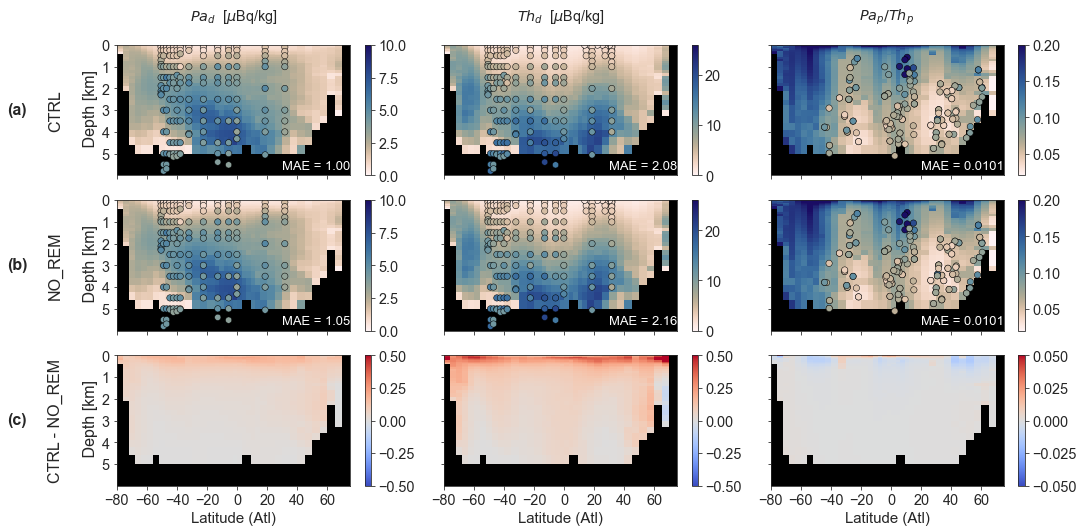

In [17]:
# zonal average in Atl for 2 runs + anomaly [optional]
# ===============================================================================
# ALTERNATIVE VERSION B: 
# seawater Pa_d, Th_d (GA02 or entire Atl) and sedimentary Pa_p / Th_p (entire Atl)
# ===============================================================================

##################### SETTINGS ######################################################
figure_nr = 7          # choose from '5' (neph), '6' (dust), '7' (remineralization term)

obs = True
sw_entire_atl = False  # otherwise we only use GA02 (West Atl) sw data (as in paper)
anomaly = True         # add 3rd row with anomaly plot
anom_free = False      # overwrites anom_zoom_in
print_mae = True       # prints MAE in the panels; desired but slower
verbose = False         # also print MAEs as text as check
rectangular = True     # make figure broader; more suitable for 16:9 slides
cmap = cmcr.lapaz_r
t=-1                   # output time step to plot

# set colour scale boundaries:
vmins = {'Pad' : 0.0, 'Thd' : 0.0, 'Pap' : 0.0, 'Thp' : 0.0, 
         'path_ratio_d' : 0.0, 'path_ratio_p' : 0.02}
vmaxs = {'Pad' : 10, 'Thd' : 26, 'Pap' : 0.4, 'Thp' : 6, 
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}
# settings for vmaxs_anom are below, depending on which figure_nr
##################### END OF SETTINGS ###############################################
print('figure_nr:', figure_nr)
print('VERSION B: seawater Pa_d, Th_d and sedimentary Pa_p / Th_p')
print("timestep: t=",t, '\n')

# define runs to use
if figure_nr == 5:    # Fig. S5
    these_runs = [best_3P5_ctrl, best_3P5_noneph_sigmas]
    vmaxs_anom = {'Pad' : 8, 'Thd' : 20, 'path_ratio_p' : 0.1}
elif figure_nr == 6:  # Fig. S6
    these_runs = [best_3P5_ctrl, best_3P5_nodust]
    vmaxs_anom = {'Pad' : 4, 'Thd' : 10, 'path_ratio_p' : 0.1}
elif figure_nr == 7:  # Fig. S7
    these_runs = [best_3P5_ctrl, best_3P5_norem]
    vmaxs_anom = {'Pad' : 0.5, 'Thd' : 0.5, 'path_ratio_p' : 0.05}
else:
    # a general setting to play around with Atl zonal averages + anomalies of other runs
    # these_runs =   # NEED TO FILL IN RUNS HERE IF PLAYING AROUND
    vmaxs_anom = {'Pad' : 2, 'Thd' : 4, 'path_ratio_p' : 0.1}
assert figure_nr in [5,6,7], "need to set figure_nr to 5, 6 or 7 (for neph, dust resp. remineralization term)"
assert len(these_runs) > 1, "This plot needs more than 1 run"

# prepare seawater Pa_d, Th_d
if sw_entire_atl:
    [this_sw, this_sw_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises='all')
else:
    [this_sw, this_sw_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises=['GA02', 'GAc02'])

sns.set_style("ticks")
if anomaly:
    nr_rows = len(these_runs)+1
else:
    nr_rows = len(these_runs)
if rectangular:
    fig, ax = plt.subplots(nr_rows,3, figsize=(15,2.5*nr_rows))
else:
    fig, ax = plt.subplots(nr_rows,3, figsize=(13,3.5*nr_rows))

xlist = data_fulls[these_runs[0]].lat_u
ylist = data_fulls[these_runs[0]].z_w
X, Y = np.meshgrid(xlist, ylist)

print('runs in order of rows:')
for n,run in enumerate(these_runs):
    print('n=',n,'so runname=', run, 'and run label=', labels[run], "@yr " + str(int(np.ceil(data_fulls[run].time[t].item()))), '\n')
    obj = data_fulls[run]

    # dissolved Atl average
    pad_global = f.model_to_sw_unit(obj.Pad.isel(time=t), obj.rho_SI.isel(time=t))
    thd_global = f.model_to_sw_unit(obj.Thd.isel(time=t), obj.rho_SI.isel(time=t))
    pad = pad_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True) 
    thd = thd_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True)        

    # particle-bound Atl average
    pap_global = f.model_to_sw_unit(obj.Pap.isel(time=t), obj.rho_SI.isel(time=t))
    thp_global = f.model_to_sw_unit(obj.Thp.isel(time=t), obj.rho_SI.isel(time=t))
    pap = pap_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True) 
    thp = thp_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True)        
    ratio = pap / thp

    if anomaly:
        # save objects
        if n==0:
            pad_run0 = pad
            thd_run0 = thd
            ratio_run0 = ratio
        if n==1:
            pad_run1 = pad
            thd_run1 = thd
            ratio_run1 = ratio                

    # Pa_d in col 1
    cpf = ax[n,0].pcolormesh(X,Y,pad.values, cmap=cmap, vmin=vmins['Pad'], vmax=vmaxs['Pad'])
    fig.colorbar(cpf, ax=ax[n,0])

    # Th_d in col 2
    cpf = ax[n,1].pcolormesh(X,Y,thd.values, cmap=cmap, vmin=vmins['Thd'], vmax=vmaxs['Thd'])
    fig.colorbar(cpf, ax=ax[n,1])

    if print_mae:
        # compute MAEs for col 1,2
        # get model data of the grid cells with obs:
        [res_d_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                            obs_ave=this_sw_obs_d_ave, convert_unit_to_obs=True)
        [weights_Pad, weights_Thd] = f.find_weights(this_sw_obs_d_ave, res_entire, volume=False, uncertainty=True)
        this_MAE_Pad = f.calc_mae(model=res_d_table.Pad, observation=this_sw_obs_d_ave.Pad, 
                                  weights=weights_Pad, verbose=verbose)
        this_MAE_Thd = f.calc_mae(model=res_d_table.Thd, observation=this_sw_obs_d_ave.Thd, 
                                  weights=weights_Thd, verbose=verbose)

        # add MAEs to plot for col 1,2
        kwargs = {'size' : 13, 'color' : 'white'}
        ax[n,0].text(30, 5.7, f'MAE = {this_MAE_Pad:.2f}', kwargs)
        ax[n,1].text(30, 5.7, f'MAE = {this_MAE_Thd:.2f}', kwargs)

    # ratio Pa_p / Th_p in col 3
    cpf = ax[n,2].pcolormesh(X,Y,(ratio).values, cmap=cmap, vmin=vmins['path_ratio_p'], vmax=vmaxs['path_ratio_p'])
    fig.colorbar(cpf, ax=ax[n,2])

    ax[n,0].set_ylabel(labels[these_runs[n]] + "\n\n Depth [km]", fontsize=16)

    if print_mae:
        # compute MAEs for col 3; TAKES A WHILE
        # obs_sed needs multi-index (lat, lon, z) for function obs_to_model_grid()
        obs_sed_indexed = obs_sed.reset_index().set_index(['lat','lon','z'], inplace=False)
        obs_sed_indexed.sort_index(inplace=True)
        [this_sed, this_sed_ave, junk2] = f.obs_to_model_grid(obs_sed_indexed, fnctrl)
        [res_p_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                            obs_ave=this_sed_ave, convert_unit_to_obs=True) # gives Pap, Thp columns so
        res_p_table['path_ratio_p'] = res_p_table.Pap / res_p_table.Thp # add ratio manually
        weights_path_ratio_p = f.find_weights(this_sed_ave, res_entire, volume=False, uncertainty=True)
        this_MAE_path_ratio_p = f.calc_mae(model=res_p_table.path_ratio_p, observation=this_sed_ave.path_ratio_p, 
                                           weights=weights_path_ratio_p, verbose=verbose)

        # add MAEs to plot for col 3
        kwargs = {'size' : 13, 'color' : 'white'}
        ax[n,2].text(20, 5.7, f'MAE = {this_MAE_path_ratio_p:.4f}', kwargs)

    if obs:
        ## ADD SEAWATER OBSERVATIONS TO COL 1,2
        ax[n,0].scatter(x=this_sw.lat, y=this_sw.z/1000.0, c=this_sw.Pad, 
                        marker='o', s=40, lw=0.5, edgecolor='k', 
                        cmap=cmap, vmin=vmins['Pad'], vmax=vmaxs['Pad'])
        # colors c convert to cmap/vmin/vmax cbar automatically; size s and linewidth lw in pixels
        ax[n,1].scatter(x=this_sw.lat, y=this_sw.z/1000.0, c=this_sw.Thd, 
                        marker='o', s=40, lw=0.5, edgecolor='k', 
                        cmap=cmap, vmin=vmins['Thd'], vmax=vmaxs['Thd'])
        # ADD SEDIMENT OBSERVATIONS TO COL 3
        ax[n,2].scatter(x=obs_sed.lat, y=obs_sed.z/1000.0, c=obs_sed.path_ratio_p, 
                        marker='o', s=40, lw=0.5, edgecolor='k', 
                        cmap=cmap, vmin=vmins['path_ratio_p'], vmax=vmaxs['path_ratio_p'])
# add 3rd row with anomaly
if anomaly:
    n = 2  # row number for in axis object
    cmap = cmp.coolwarm

    # dissolved Atl average
    pad = pad_run0 - pad_run1
    thd = thd_run0 - thd_run1 

    # particle-bound Atl average
    ratio = ratio_run0 - ratio_run1

    if anom_free:
        cpf = ax[n,0].pcolormesh(X,Y,pad.values, cmap=cmap)
        fig.colorbar(cpf, ax=ax[n,0])
        cpf = ax[n,1].pcolormesh(X,Y,thd.values, cmap=cmap)
        fig.colorbar(cpf, ax=ax[n,1])
        cpf = ax[n,2].pcolormesh(X,Y,(ratio).values, cmap=cmap)
        fig.colorbar(cpf, ax=ax[n,2])
    else:
        cpf = ax[n,0].pcolormesh(X,Y,pad.values, cmap=cmap, vmin=-vmaxs_anom['Pad'], vmax=vmaxs_anom['Pad'])
        fig.colorbar(cpf, ax=ax[n,0])
        cpf = ax[n,1].pcolormesh(X,Y,thd.values, cmap=cmap, vmin=-vmaxs_anom['Thd'], vmax=vmaxs_anom['Thd'])
        fig.colorbar(cpf, ax=ax[n,1])
        cpf = ax[n,2].pcolormesh(X,Y,ratio.values, cmap=cmap, vmin=-vmaxs_anom['path_ratio_p'], vmax=vmaxs_anom['path_ratio_p'])
        fig.colorbar(cpf, ax=ax[n,2])

    ax[n,0].set_ylabel(labels[these_runs[0]] + " - " + labels[these_runs[1]] + "\n\n Depth [km]", fontsize=16)

for i in range(0, nr_rows):
    for j in range(0, 3):
        ax[i,j].invert_yaxis()
        ax[i,j].set_xlim(-80,75)
        ax[i,j].set_xticks(range(-80,65,20))
        ax[i,j].set_yticks(range(0,6))
        ax[i,j].set_facecolor('k')  # turn ocean topography black
        if j != 0:
            ax[i,j].set_yticklabels([])  # clean ticks
        if anomaly:
            ax[len(these_runs),j].set_xlabel('Latitude (Atl)', fontsize=15)
            if i < len(these_runs):
                ax[i,j].set_xticklabels([])  # clean ticks
        else:
            ax[len(these_runs)-1,j].set_xlabel('Latitude (Atl)', fontsize=15)
            if i < len(these_runs)-1:
                ax[i,j].set_xticklabels([])  # clean ticks
        if obs:
            # go to 6 km instead of 5 km such that all subplots have same depth
            ax[i,j].set_ylim(6,0)  # deepest obs at 5815 m
        if j == 0:
            ax[i,j].text(-0.47, 0.47, '(' + chr(ord('a')+i) + ')', transform=ax[i,j].transAxes, 
                         size=16, weight='bold')

ax[0,0].set_title("$Pa_d$  [$\mu$Bq/kg]" + "\n")
ax[0,1].set_title("$Th_d$  [$\mu$Bq/kg]" + "\n")
ax[0,2].set_title("$Pa_p/Th_p$" + " \n")

plt.tight_layout()
if obs:
    obs_label = 'obs_'
    if sw_entire_atl:
        # seawater: entire Atl; sediment: entire Atl
        obs_label += 'entire_atl_' 
    else:
        # seawater: GA02 (West transect); sediment: entire Atl
        obs_label += 'sw_GA02_sed_entire_atl_'
else:
    obs_label = '_no_obs_'
plt.savefig(savedir / (obs_label + labels[these_runs[0]] + "_" + labels[these_runs[1]] + '.pdf'))

In [15]:
# compute all kinds of MAEs

#### SETTINGS ########################
run = these_runs[1]   # select run 0 or 1; these_runs used from above

## pick one of these:
these_cruises = ['GA02','GAc02']  # for checking that Pad, Thd agrees to the MAE in figure
# these_cruises = cruises_Atl_wo_SO
# these_cruises = cruises_Pac_wo_SO
# these_cruises = cruises_Atl  # incl Atl SO 
# these_cruises = cruises_Pac  # incl Pac SO 
# these_cruises = cruises_SO

verbose = False
######################################
print('run: ', labels[run])
print('these_cruises: ', these_cruises,'\n')

# prepare obs data (ONLY NEEDED ONCE)
[this_sw, this_sw_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises=these_cruises)
this_obs_p = obs_p.drop(columns='path_ratio_p', inplace=False)
[this_obs_p, this_sw_obs_p_ave, junk2] = f.subset_of_obs(this_obs_p, fnctrl, cruises=these_cruises)
print('\n')

# MAE with dissolved sw data
[res_d_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                        obs_ave=this_sw_obs_d_ave, convert_unit_to_obs=True)
[weights_Pad, weights_Thd] = f.find_weights(this_sw_obs_d_ave, res_entire, volume=False, uncertainty=True)
this_MAE_Pad = f.calc_mae(model=res_d_table.Pad, observation=this_sw_obs_d_ave.Pad, 
                            weights=weights_Pad, verbose=verbose)
this_MAE_Thd = f.calc_mae(model=res_d_table.Thd, observation=this_sw_obs_d_ave.Thd, 
                            weights=weights_Thd, verbose=verbose)
print(f'MAE_Pad = {this_MAE_Pad:.3f}')
print(f'MAE_Thd = {this_MAE_Thd:.3f}')

# MAE with particle-bound sw data
if len(this_sw_obs_p_ave) == 0:
   print('\n' + f'MAE_Pap = nan')
   print(f'MAE_Thp = nan')   
   print('because no particle-bound sw data available for cruises ' + str(these_cruises))
else: 
   [res_p_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                          obs_ave=this_sw_obs_p_ave, convert_unit_to_obs=True)
   [weights_Pap, weights_Thp] = f.find_weights(this_sw_obs_p_ave, res_entire, volume=False, uncertainty=True)
   this_MAE_Pap = f.calc_mae(model=res_p_table.Pap, observation=this_sw_obs_p_ave.Pap, 
                              weights=weights_Pap, verbose=verbose)
   this_MAE_Thp = f.calc_mae(model=res_p_table.Thp, observation=this_sw_obs_p_ave.Thp, 
                              weights=weights_Thp, verbose=verbose)
   print(f'MAE_Pap = {this_MAE_Pap:.5f}')
   print(f'MAE_Thp = {this_MAE_Thp:.5f}')

run:  NO_NEPH
these_cruises:  ['GA02', 'GAc02'] 

Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.


Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


MAE_Pad = 1.494
MAE_Thd = 1.881

MAE_Pap = nan
MAE_Thp = nan
because no particle-bound sw data available for cruises ['GA02', 'GAc02']
